# 더 멋진 번역기 만들기

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sentencepiece as spm
from tqdm.notebook import tqdm

import os
import random
import re

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## Step 1. 데이터 다운로드 (클라우드 유저용)

In [3]:
!ln -s ~/data ~/aiffel/transformer/data

ln: failed to create symbolic link '/aiffel/aiffel/transformer/data/data': Read-only file system


## Step 2. 데이터 정제 및 토큰화

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # 중복 데이터 제거
    cleaned_corpus = list(set(map(lambda x: x[0] + '\t' + x[1], zip(kor, eng))))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [5]:
def preprocess_sentence(sentence):
    # 영문자 소문자화
    sentence = sentence.lower()
    # 한글, 영문자, 문장부호를 제외한 글자 제거하기
    sentence = re.sub(r'[^a-zㄱ-ㅎ가-힣\.,!? ]', '', sentence)
    # 문장부호 단일 토큰화
    sentence = re.sub(r'[\.,!?]', ' \1 ', sentence)
    # 문장 양옆 빈칸 제거하기
    sentence = sentence.strip()
    
    return sentence

In [6]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # 코퍼스를 텍스트 파일로 저장
    with open(lang + '_corpus.txt', 'w') as f:
        for line in corpus:
            f.write(line + '\n')
            
    # 저장한 코퍼스를 SentencePiece에 학습
    if not os.path.exists(lang + '.model'): # 이미 있다면 새로 학습하지 않음
        spm.SentencePieceTrainer.train(
            input=lang + '_corpus.txt',
            model_prefix=lang,
            vocab_size=vocab_size,
            #model_type='bpe',
            pad_id=pad_id,
            bos_id=bos_id,
            eos_id=eos_id,
            unk_id=unk_id,
            pad_piece='<PAD>',
            bos_piece='<BOS>',
            eos_piece='<EOS>',
            unk_piece='<UNK>',
        )

    # 학습 완료된 토크나이저 불러오기
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(lang+'.model')

    return tokenizer
    

# 사전 크기
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

# 코퍼스 전처리
for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

# 토큰화
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos") # 양 옆에 시작 토큰과 종료 토큰 추가

True

In [7]:
src_corpus = []
tgt_corpus = []

# 원본 문장과 목적 문장의 개수가 동일한지 검사
assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남기기
for idx in tqdm(range(len(kor_corpus))):
    src_tensor = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    tgt_tensor = en_tokenizer.encode_as_ids(eng_corpus[idx])
    if len(src_tensor) <= 50 and len(tgt_tensor) <= 50:
        src_corpus.append(src_tensor)
        tgt_corpus.append(tgt_tensor)

# 패딩처리
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [8]:
print('enc_train max length:', max(map(lambda x: x.shape[0], enc_train)))
print('dec_train max length:', max(map(lambda x: x.shape[0], dec_train)))

enc_train max length: 50
dec_train max length: 50


## Step 3. 모델 설계 

### 포지셔널 인코딩

In [9]:
# 사인파 포지셔널 인코딩
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

### Multi-head Attention

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        Q = [ batch x heads x length x depth ]
        K = [ batch x heads x length x depth ]
        """
        # qk = (batch_size, n_heads, length(Q), length(K))
        qk = tf.linalg.matmul(Q, K, transpose_b=True)
        scaled_qk = qk / tf.math.sqrt(tf.cast(Q.shape[-1], 'float32'))

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """
        # scaled_qk = [ batch x heads x length(Q) x length(K) ]
        # V = [ batch x heads x length x depth ]
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)
        return out, attentions

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수
        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch, length = x.shape[0], x.shape[1]
        split_x = tf.reshape(x, [batch, length, self.num_heads, self.depth])
        split_x = tf.transpose(split_x, [0, 2, 1, 3])
        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x heads x length x self.depth ]
        return: [ batch x length x emb ]
        """
        batch, length = x.shape[0], x.shape[2]
        combined_x = tf.transpose(x, [0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, [batch, length, self.d_model])
        return combined_x

    def call(self, Q, K, V, mask):
        # Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)

        # Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
        #         -> out, attention_weights
        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split, mask)
        
        # Step 4: Combine Heads(out) -> out
        out = self.combine_heads(out)
        
        # Step 5: Linear_out(out) -> out
        out = self.linear(out)

        return out, attention_weights

### Position-wise Feed Forward Network

In [11]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)         
        return out

### Encoder Block 

In [12]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        # Encoder Self Attention
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        
        # Feed Forward
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn

### Decoder Block

In [13]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        # decoder self attention
        self.layerNorm1 = tf.keras.layers.LayerNormalization()
        self.attention1 = MultiHeadAttention(d_model, n_heads)
        
        # encoder decoder attention
        self.layerNorm2 = tf.keras.layers.LayerNormalization()
        self.attention2 = MultiHeadAttention(d_model, n_heads)
        
        # feed forward
        self.layerNorm3 = tf.keras.layers.LayerNormalization()
        self.feedForward = PoswiseFeedForwardNet(d_model, d_ff)
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):
        x = self.layerNorm1(x)
        out, dec_attn = self.attention1(x, x, x, padding_mask)
        out = self.dropout(out)
        x = out + x

        x = self.layerNorm2(x)
        out, dec_enc_attn = self.attention2(x, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        x = out + x

        x = self.layerNorm3(x)
        out = self.feedForward(x)
        out = self.dropout(out)
        x = out + x

        return out, dec_attn, dec_enc_attn

### Encoder

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

    def call(self, x, mask):
        out = x
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

### Decoder 

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]

    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer 모델 전체 

In [16]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        # Embedding + Positional Encoding
        self.enc_embedding = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_embedding = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        # Encoder + Decoder
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # Last Linear
        self.linear = tf.keras.layers.Dense(tgt_vocab_size)
        self.dropout = tf.keras.layers.Dropout(dropout)
        
        # Shared Weight Setting
        self.shared = shared
        if shared:
            self.linear.set_weights(tf.transpose(self.dec_embedding.get_weights()))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)
        
        if self.shared:
            out = out * tf.math.sqrt(self.d_model)
            
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        enc_in = self.embedding(self.enc_embedding, enc_in)
        dec_in = self.embedding(self.dec_embedding, dec_in)
        
        # Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        # Step 3: Decoder(dec_in, enc_out, mask)
        #         -> dec_out, dec_attns, dec_enc_attns
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # Step 4: Out Linear(dec_out) -> logits
        logits = self.linear(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

### 마스크 생성 함수 

In [17]:
# 패딩 마스크
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# 인과관계 마스크
def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

# 마스크 생성 함수
def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)
    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## Step 4. 훈련하기

### Model

In [18]:
n_layers = 2
d_model = 128
n_heads = 8
d_ff = 256
src_vocab_size = 20000
tgt_vocab_size = 20000
pos_len = 50

transformer = Transformer(n_layers,
                          d_model,
                          n_heads,
                          d_ff,
                          src_vocab_size,
                          tgt_vocab_size,
                          pos_len,
                          dropout=0.2,
                          shared=True)

### Learning Rate Scheduler & Optimizer

In [19]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### Loss function

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### Train Step

In [21]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
            model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### Train Loop 

In [22]:
BATCH_SIZE = 64
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0

    # 데이터셋 섞기
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss, _, _, _ = train_step(enc_train[idx:idx+BATCH_SIZE], # batch를 직접 지정
                                         dec_train[idx:idx+BATCH_SIZE],
                                         transformer,
                                         optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

  0%|          | 0/837 [00:00<?, ?it/s]

## 모델 검증 및 어텐션 시각화

### 어텐션 가중치 시각화 

In [23]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
    
    # 인코더 어텐션 가중치
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
    
    # 디코더 어텐션 가중치
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

### 평가 함수 

In [24]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    # 전처리
    sentence = preprocess_sentence(sentence)

    # 토큰화
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    # 패딩 추가
    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    # 번역 문장 생성
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        # 마스크 생성
        enc_padding_mask, combined_mask, dec_padding_mask = \
            generate_masks(_input, output)

        # 다음 단어 추론
        predictions, enc_attns, dec_attns, dec_enc_attns =\
            model(_input, 
                  output,
                  enc_padding_mask,
                  combined_mask,
                  dec_padding_mask)

        # 추론 결과 인덱스화
        predicted_id = \
            tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        # 종료 토큰 생성시 문장 생성 종료
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        
        # 생성된 토큰 저장
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    # 번역 결과 디코딩
    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

### 모델 추론 결과 평가

In [25]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
        evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama obama obama obama in
Encoder Layer 1


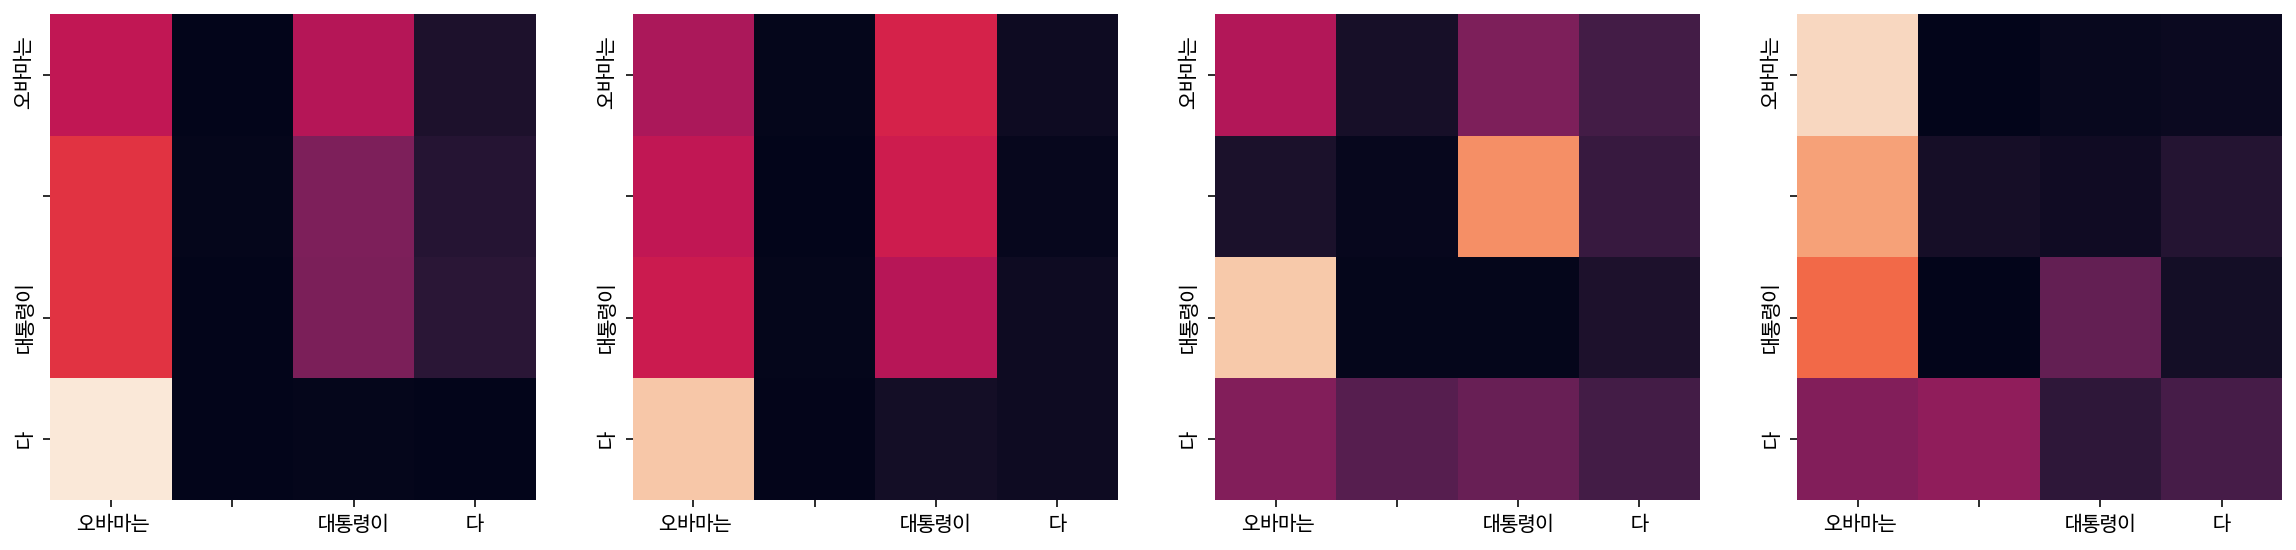

Encoder Layer 2


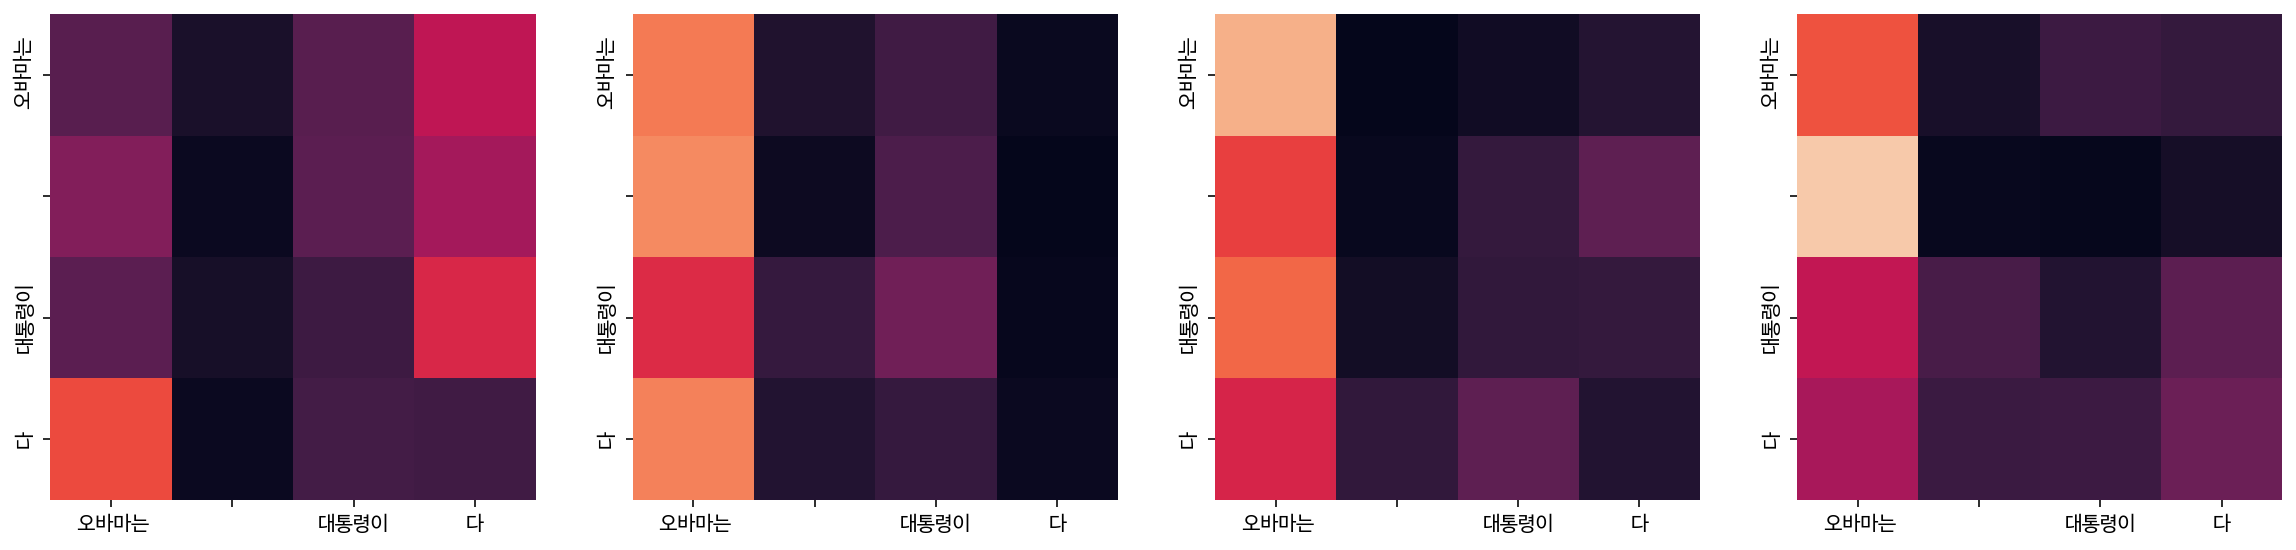

Decoder Self Layer 1


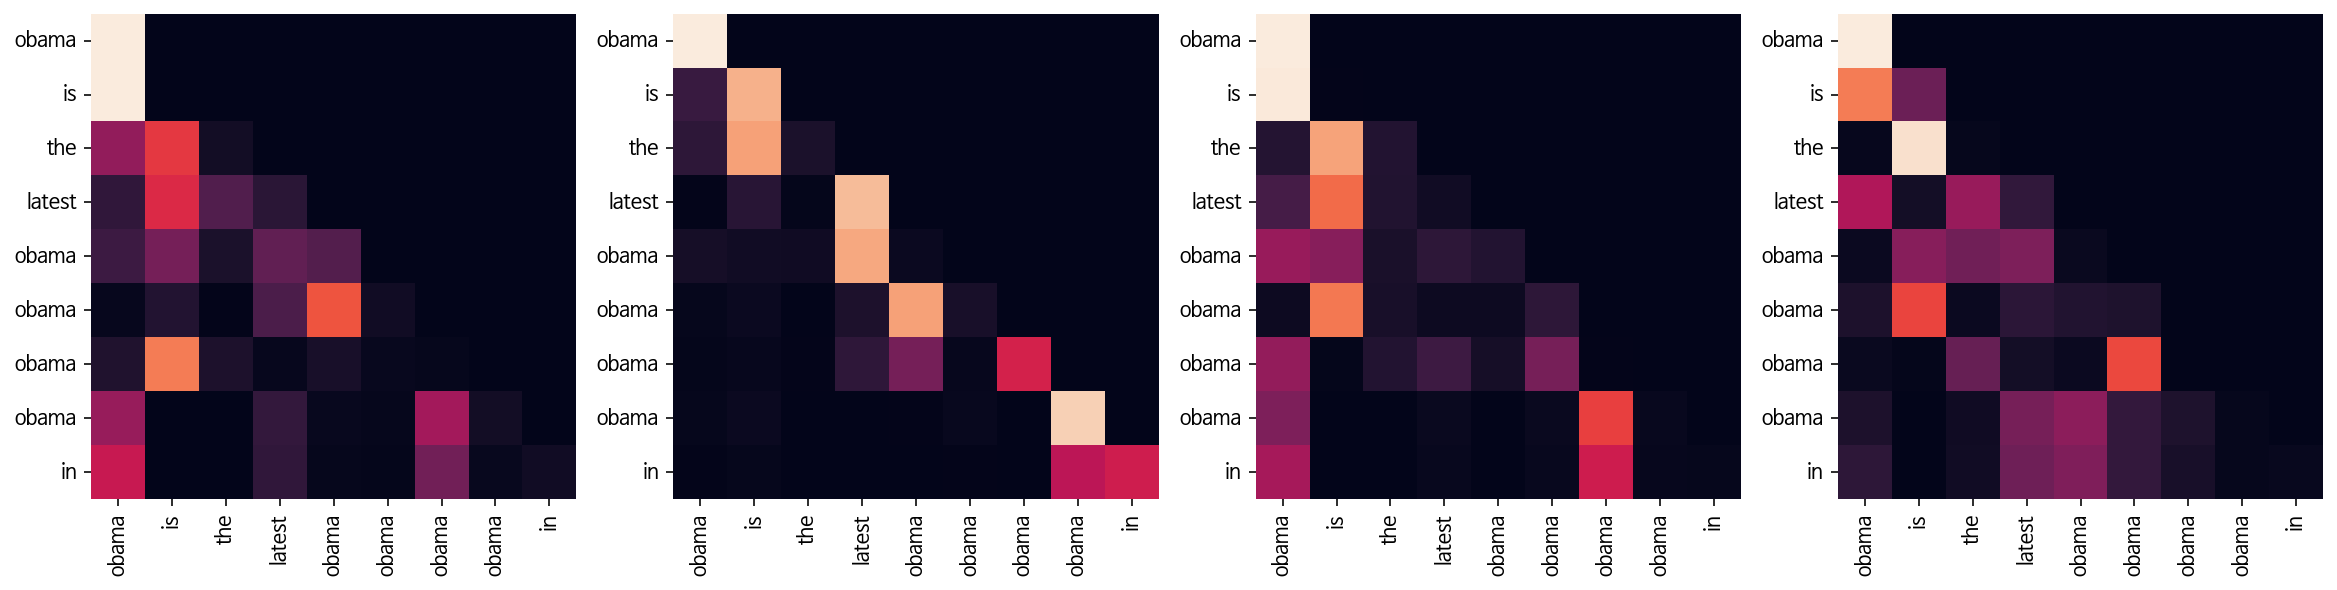

Decoder Src Layer 1


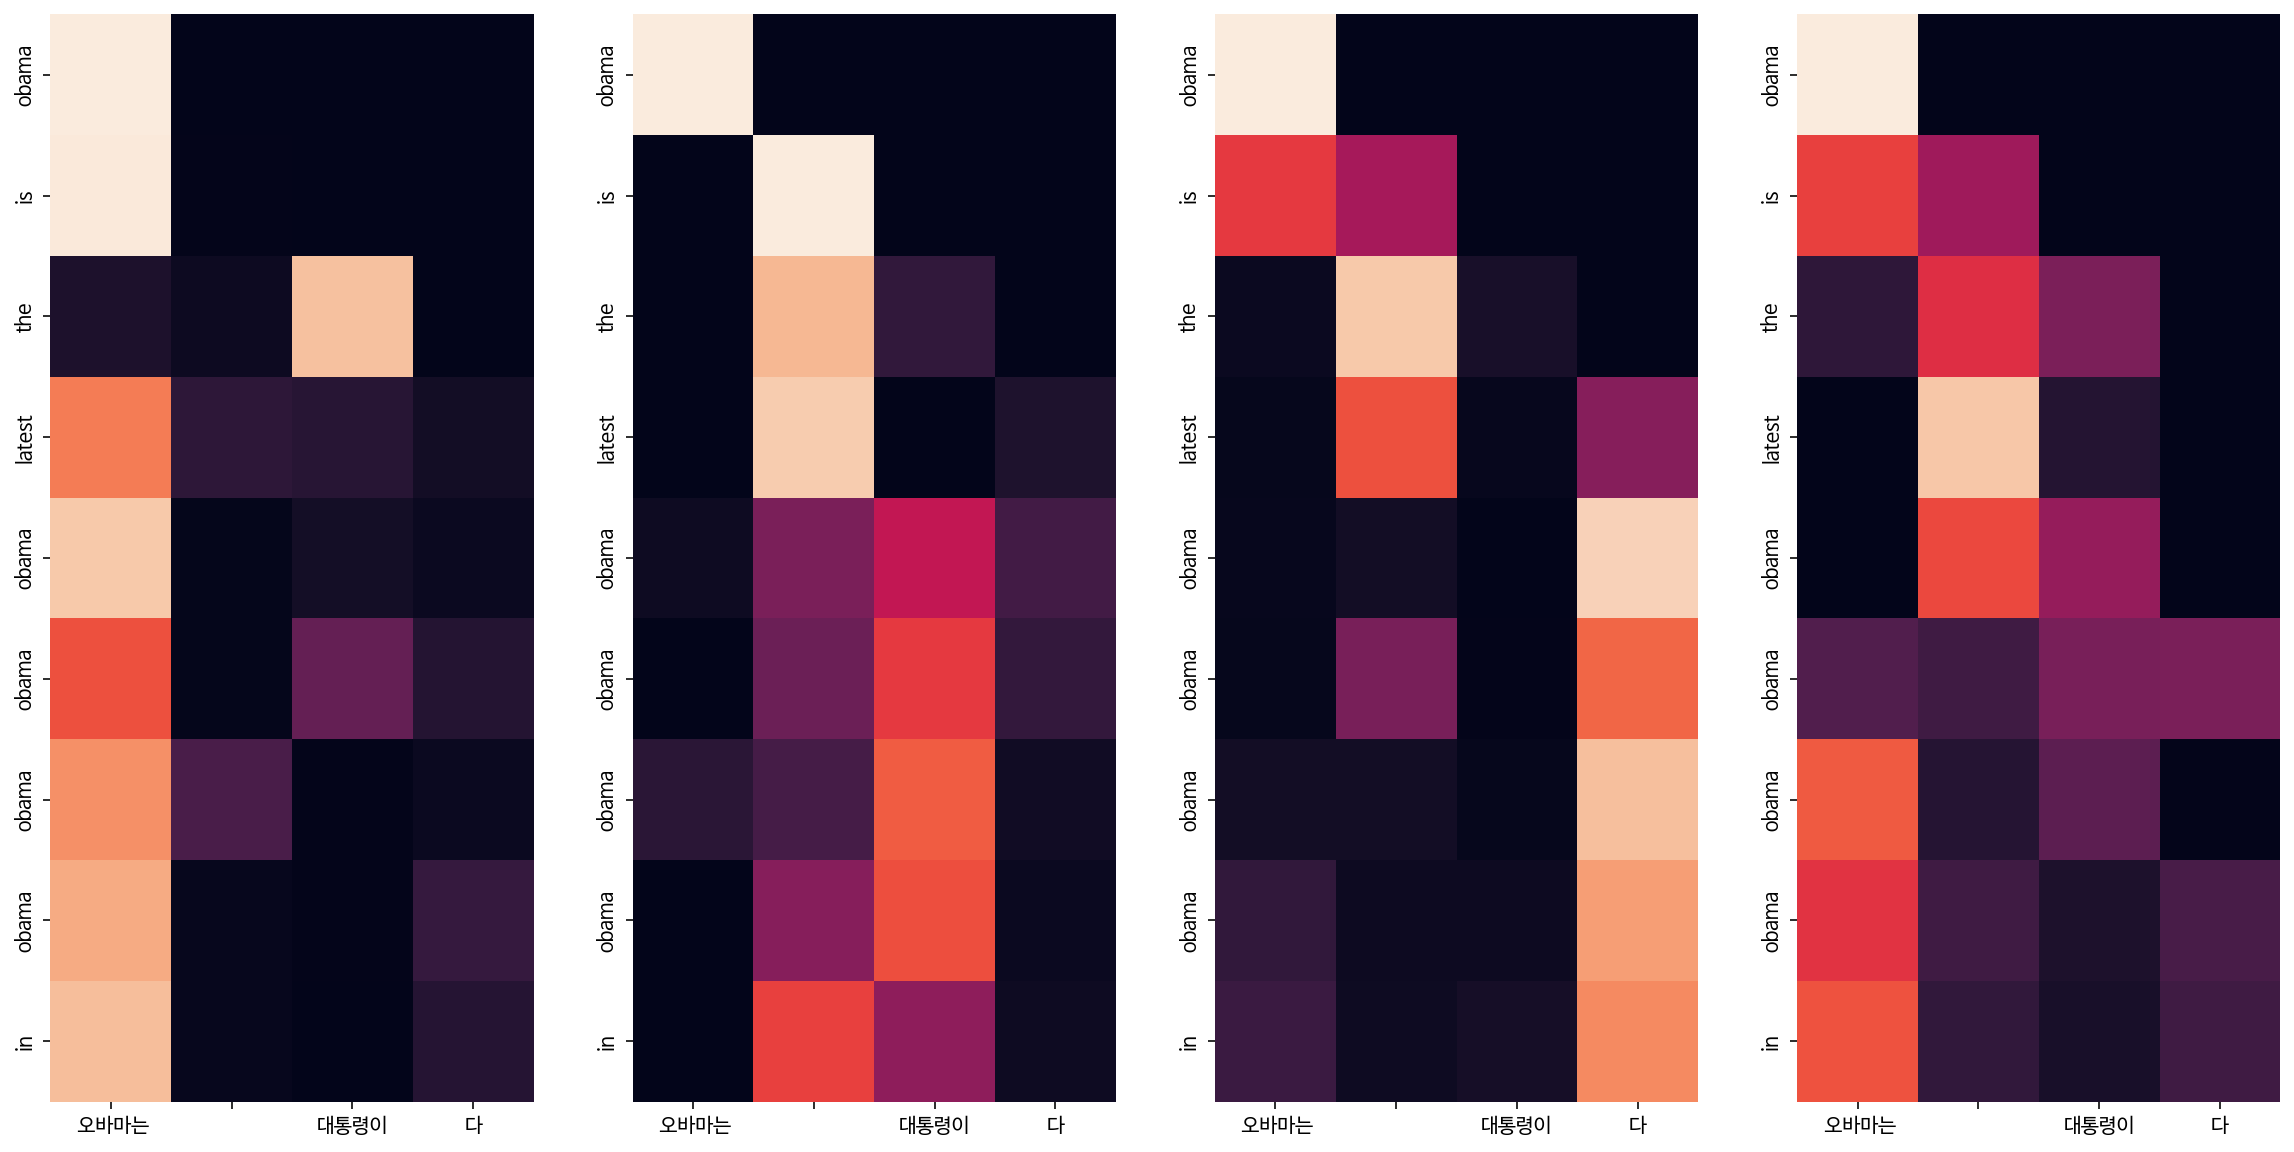

Decoder Self Layer 2


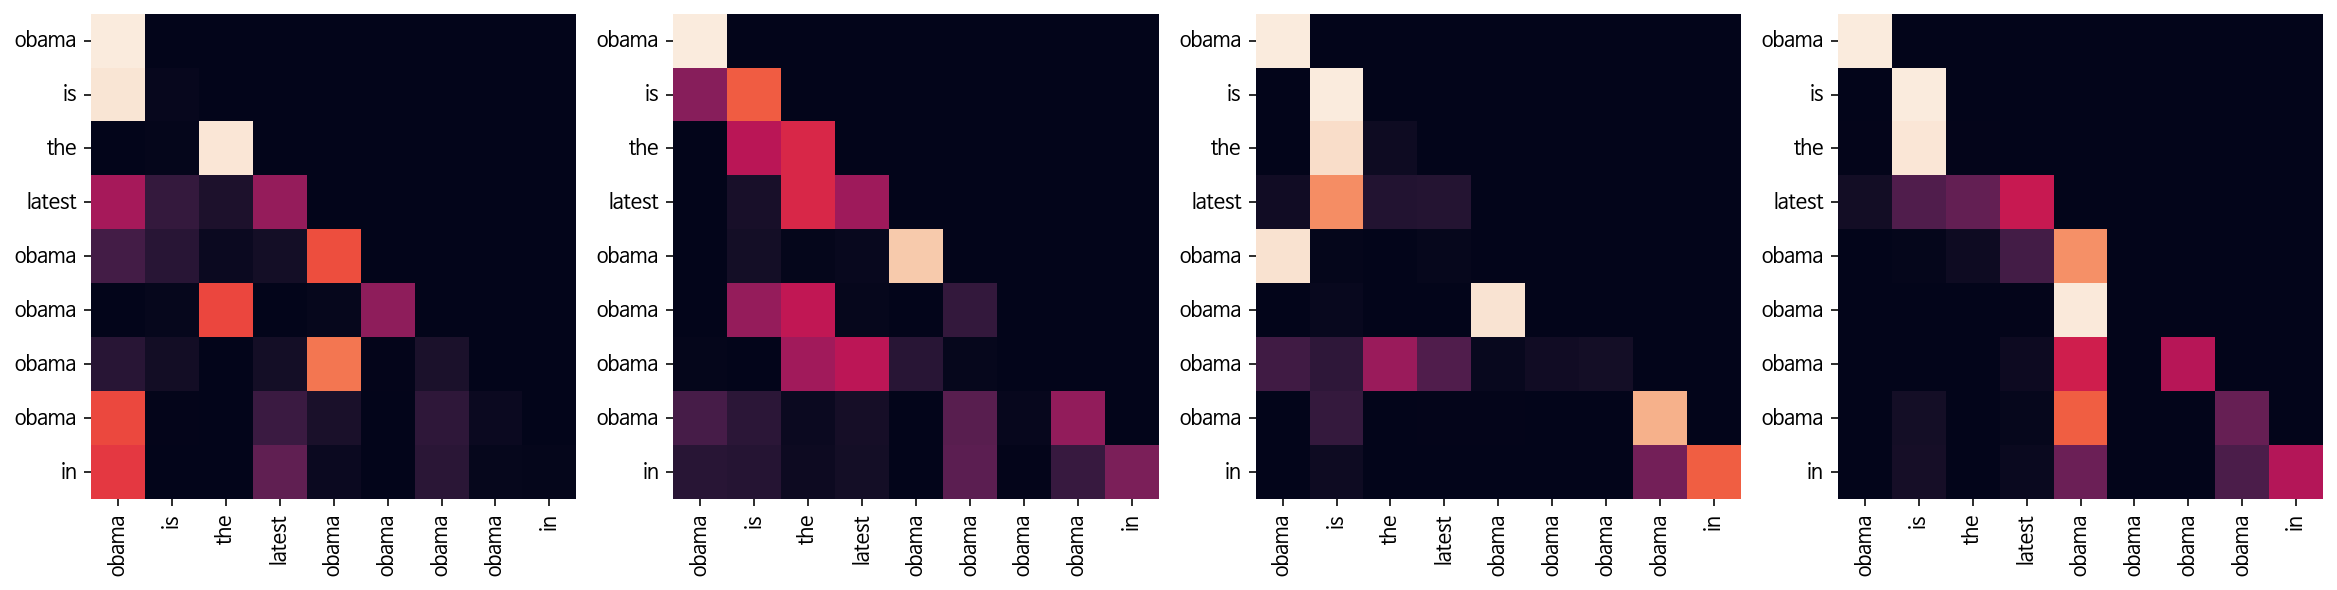

Decoder Src Layer 2


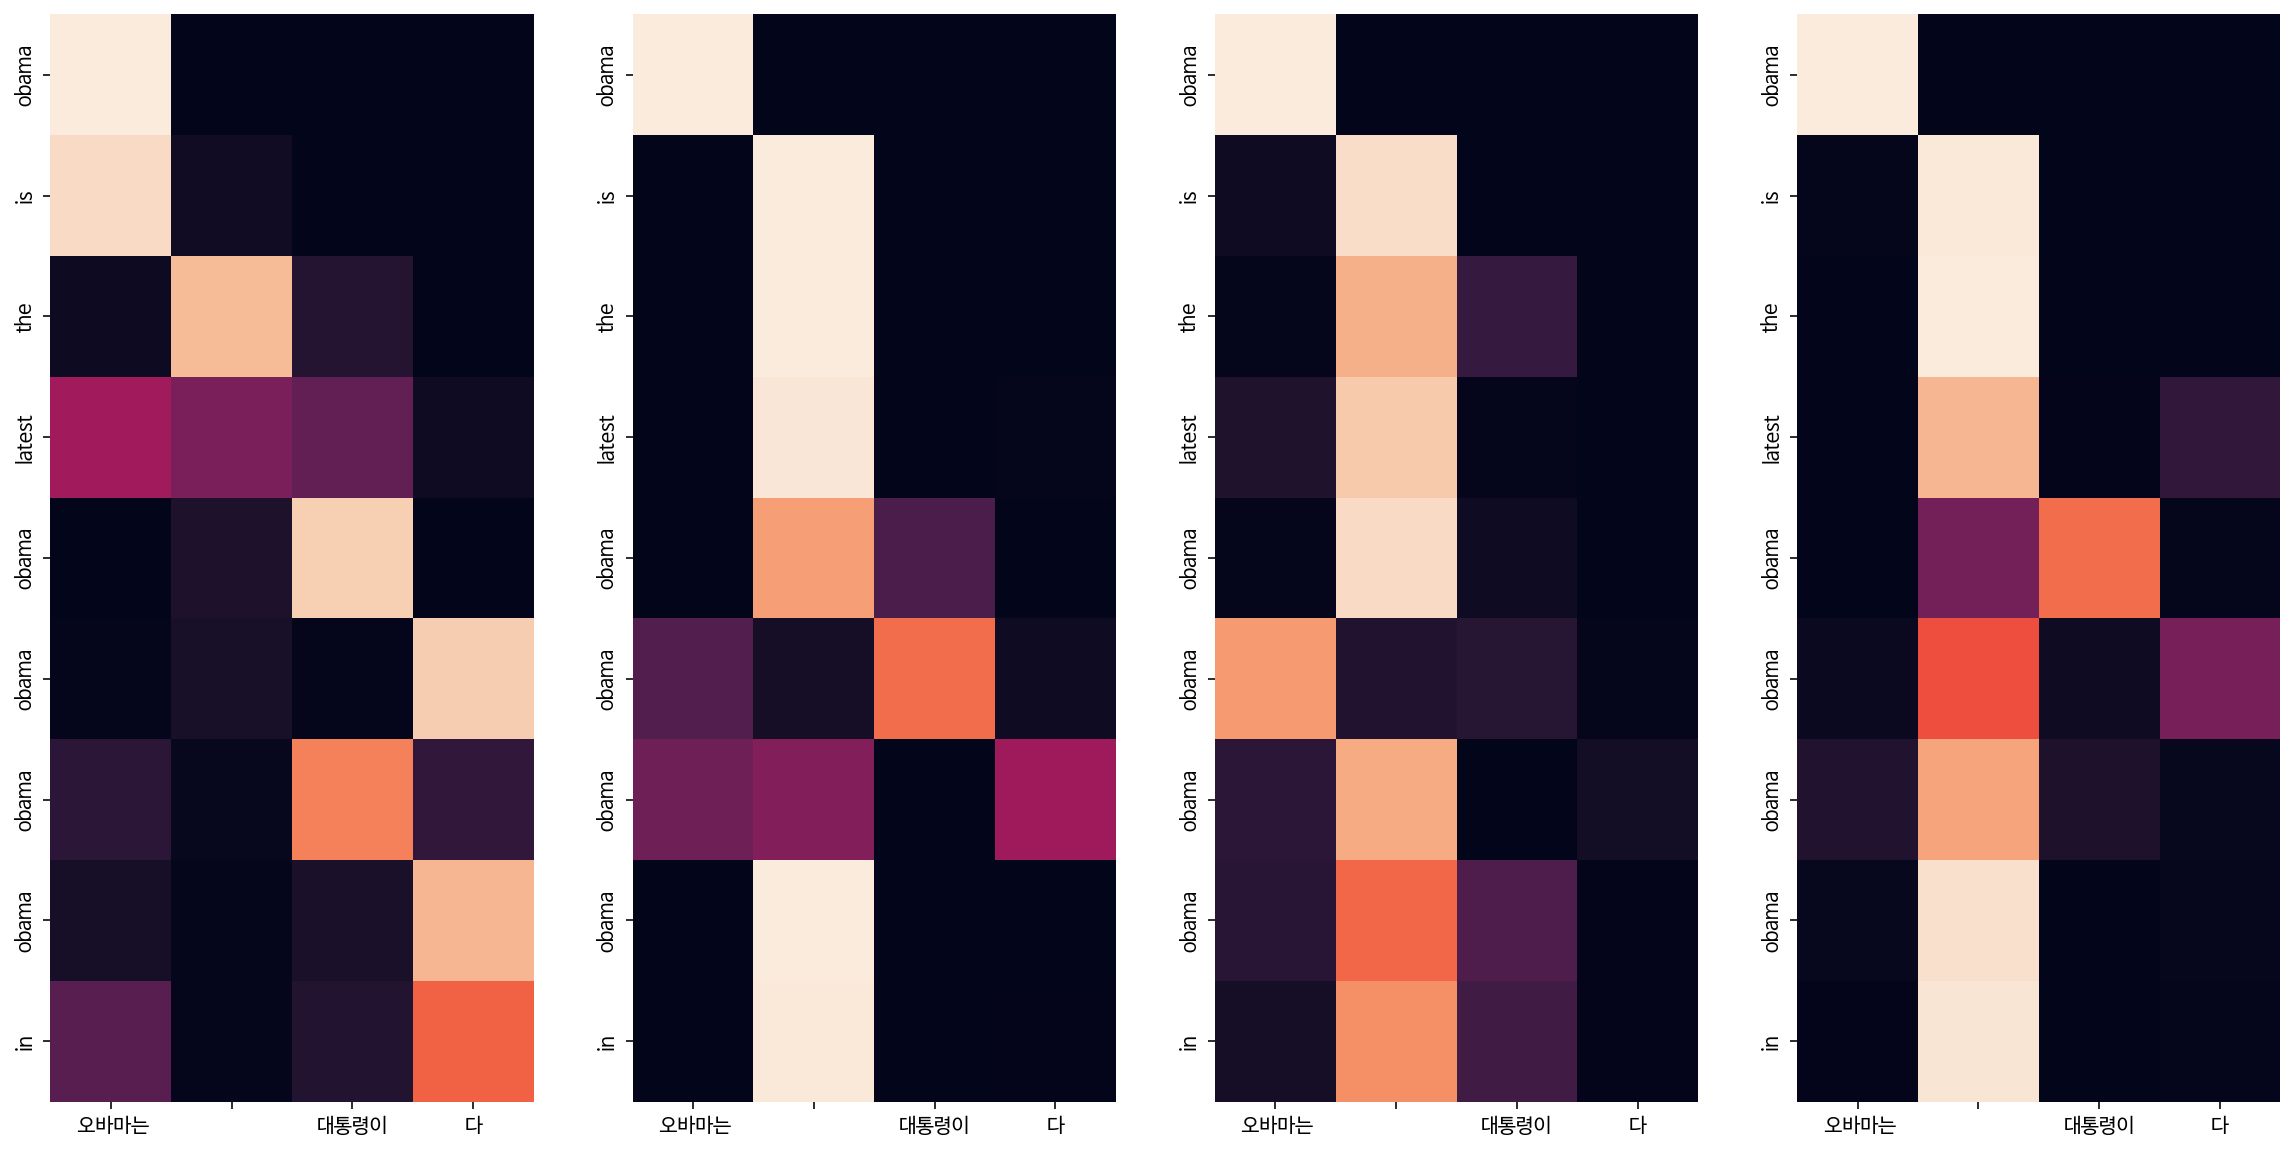

In [28]:
translate("오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 시민들은 도시 속에 산다.
Predicted translation: that known as the town of known known as the town of known as known as cities
Encoder Layer 1


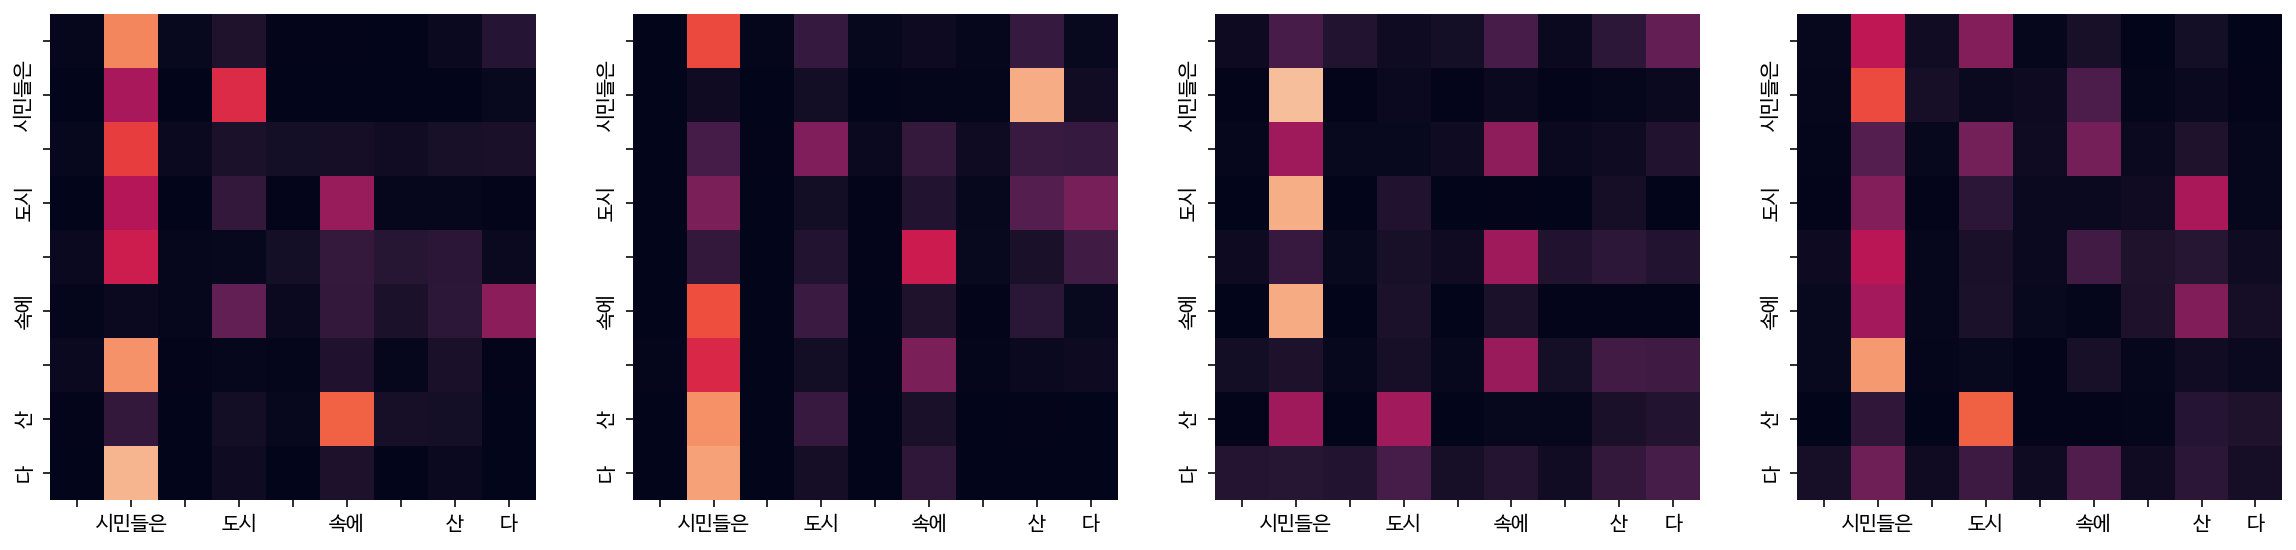

Encoder Layer 2


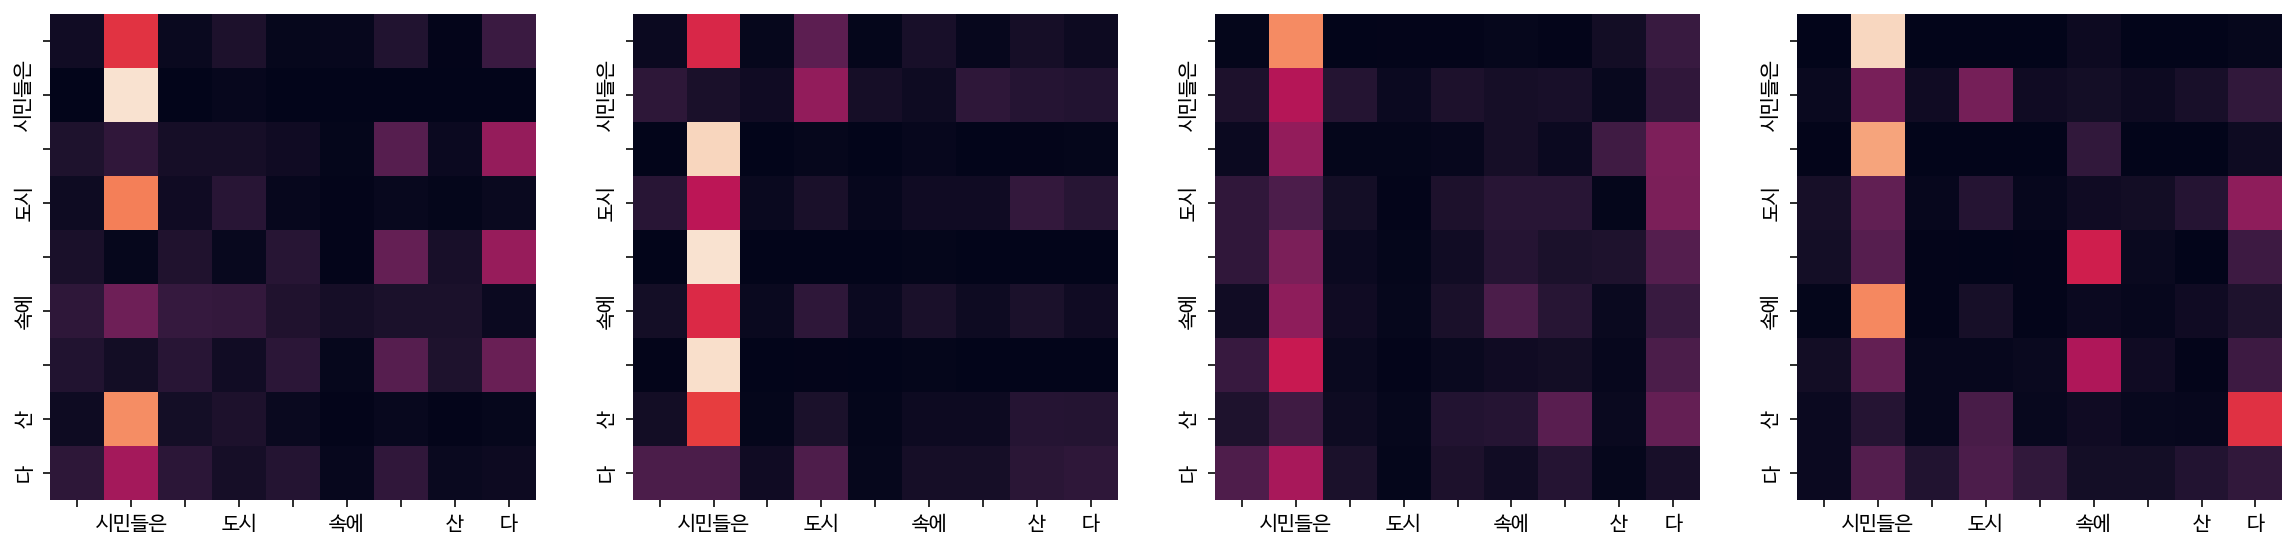

Decoder Self Layer 1


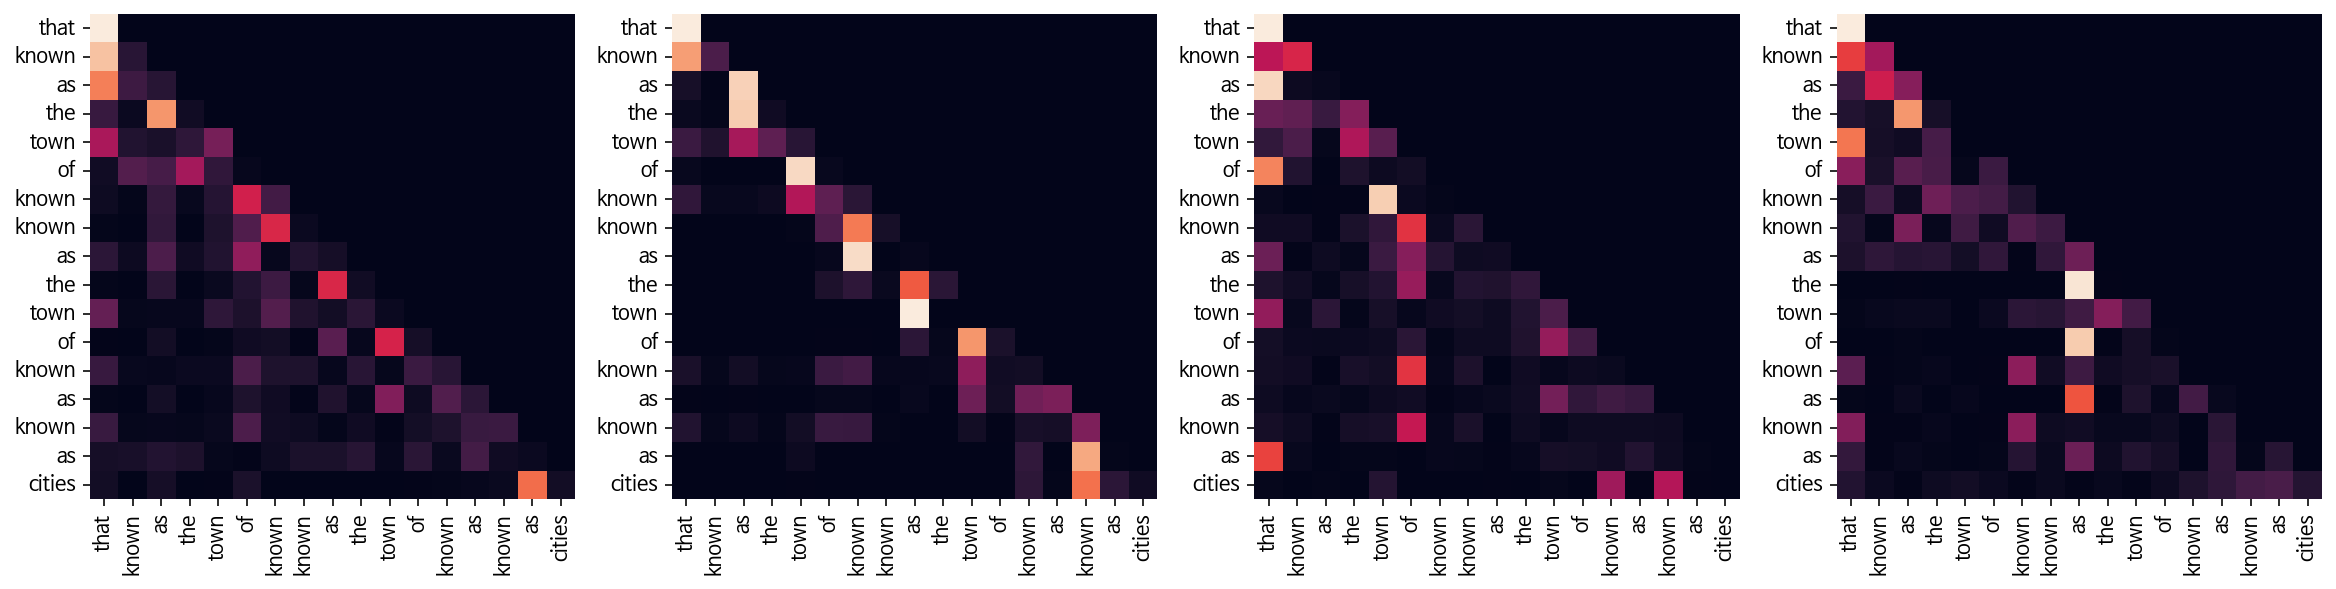

Decoder Src Layer 1


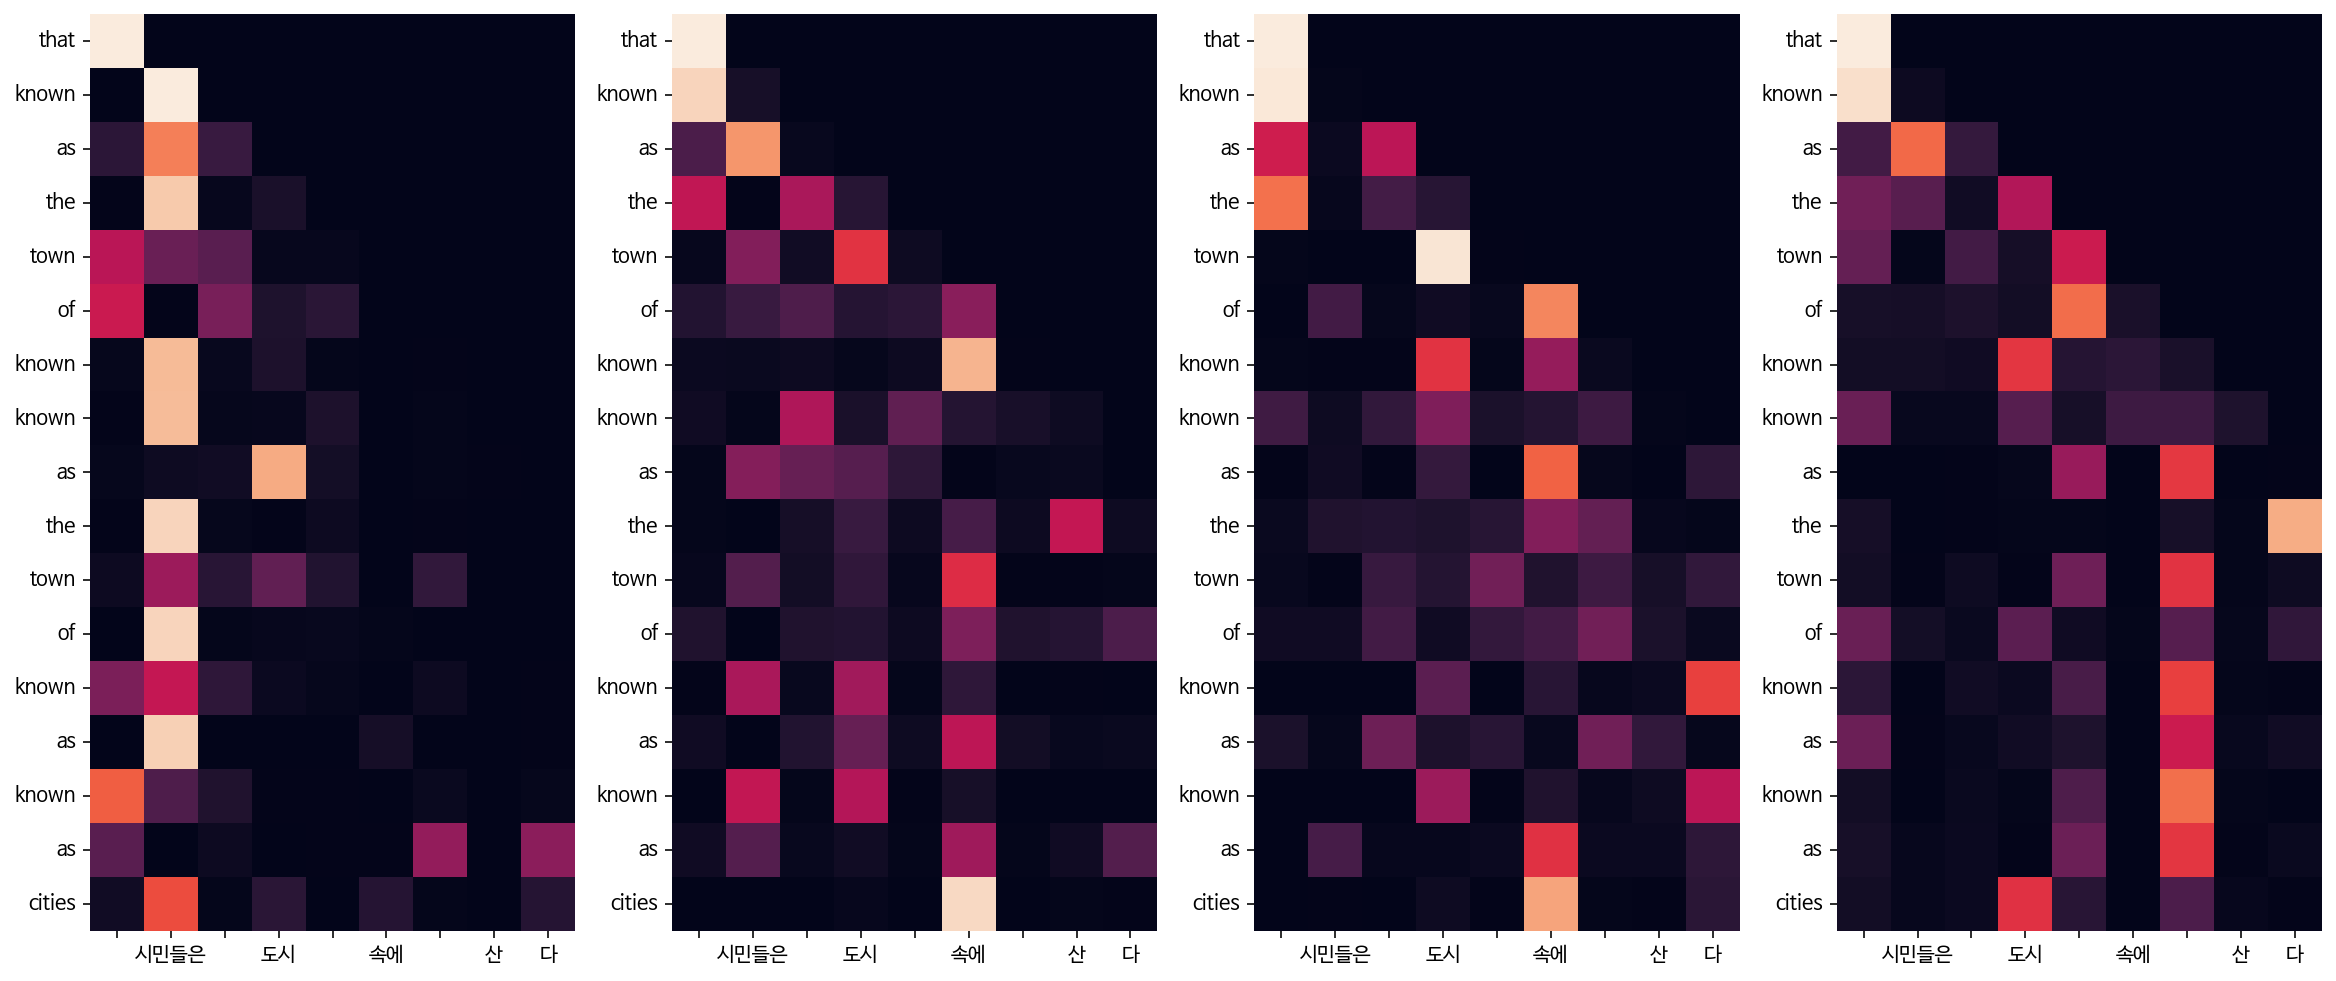

Decoder Self Layer 2


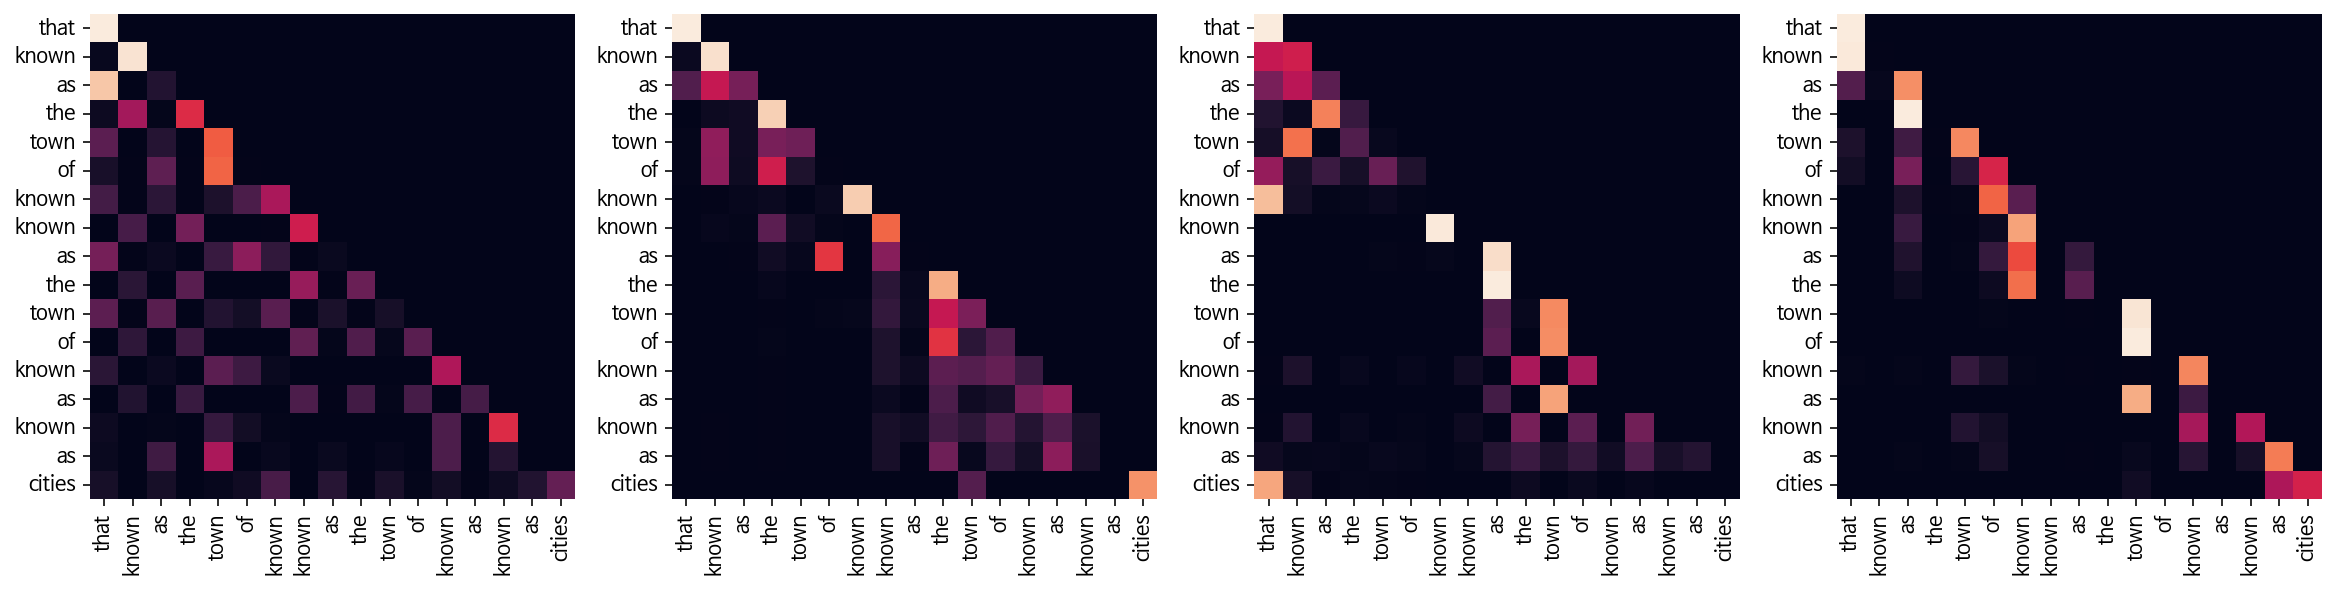

Decoder Src Layer 2


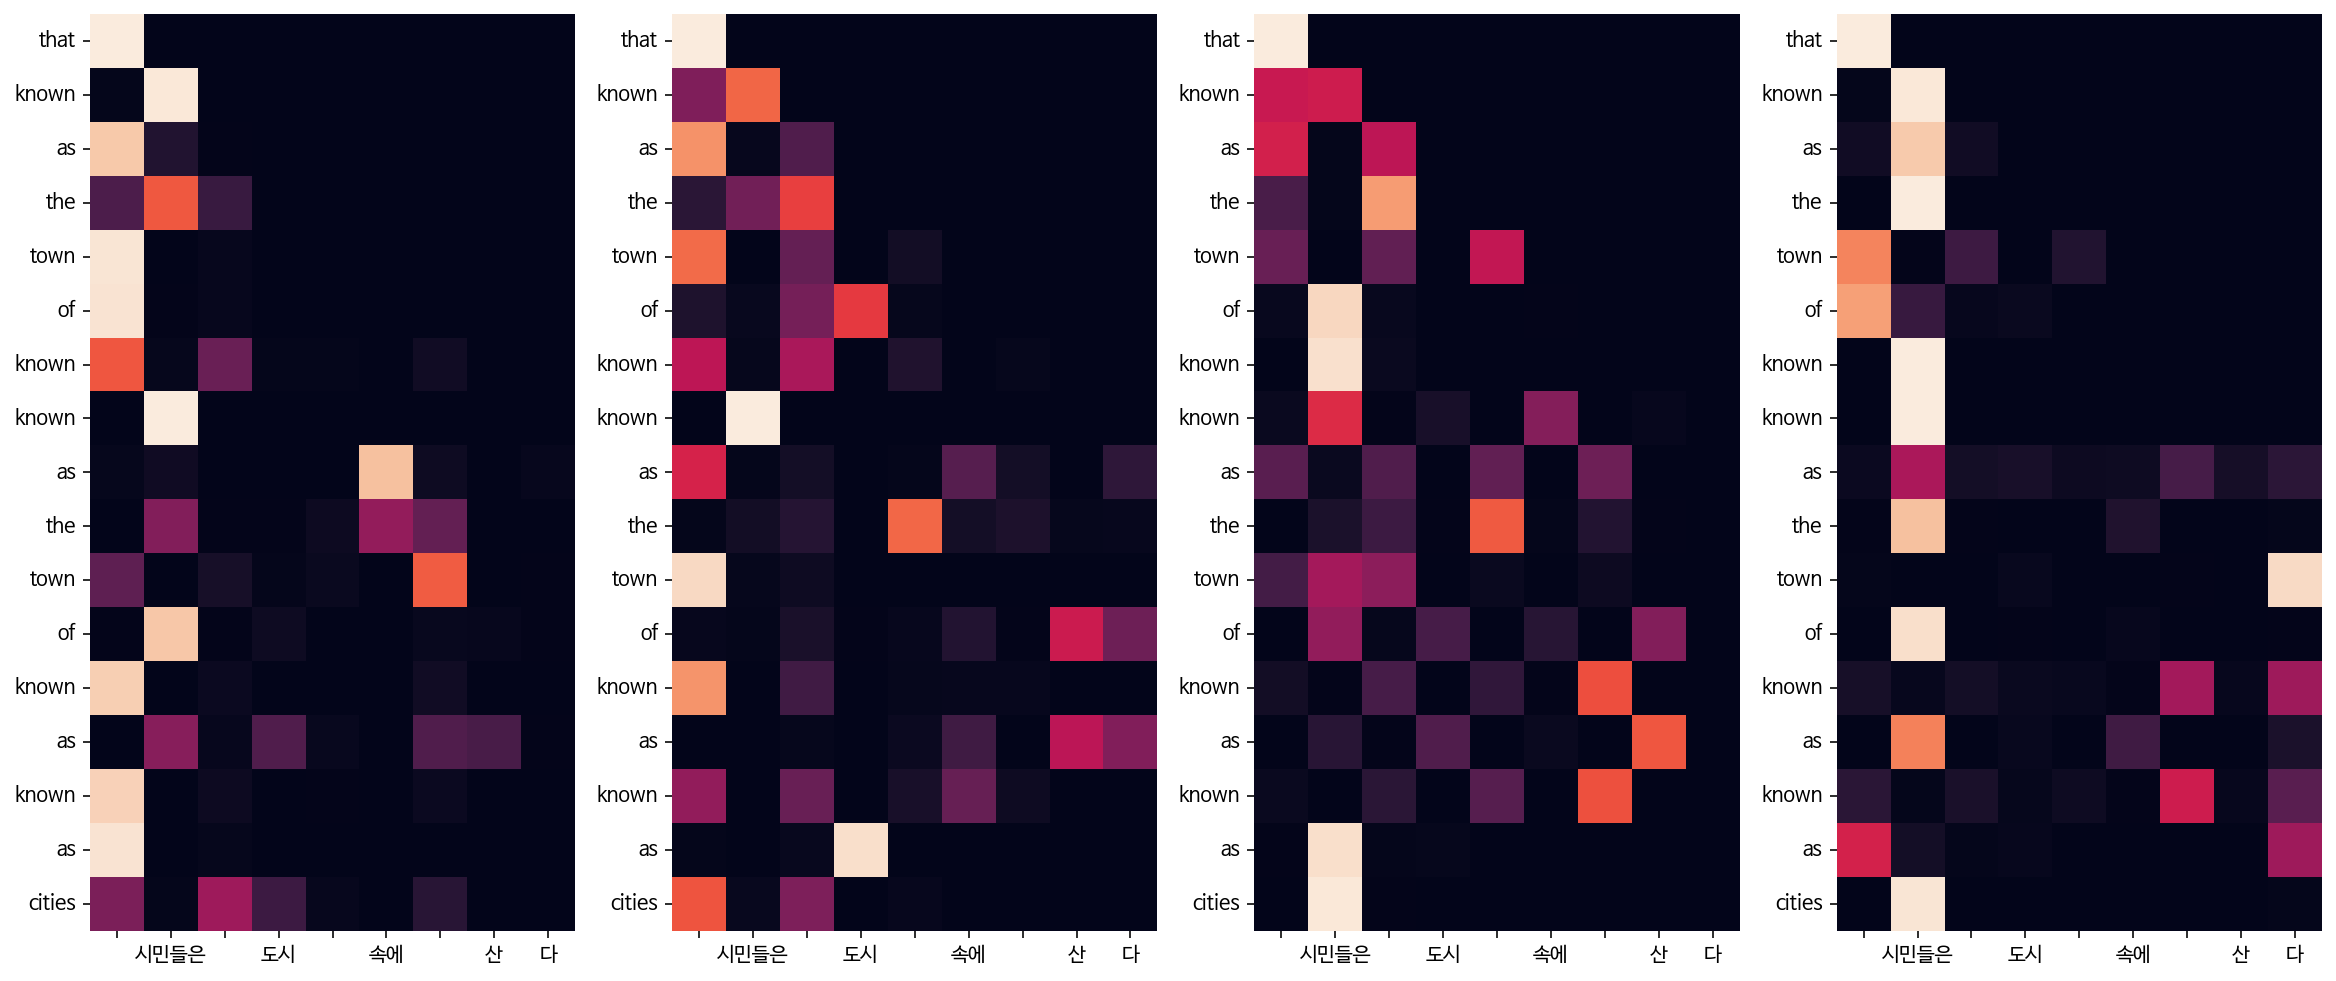

In [29]:
translate("시민들은 도시 속에 산다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 커피는 필요없다.
Predicted translation: coffee has no game
Encoder Layer 1


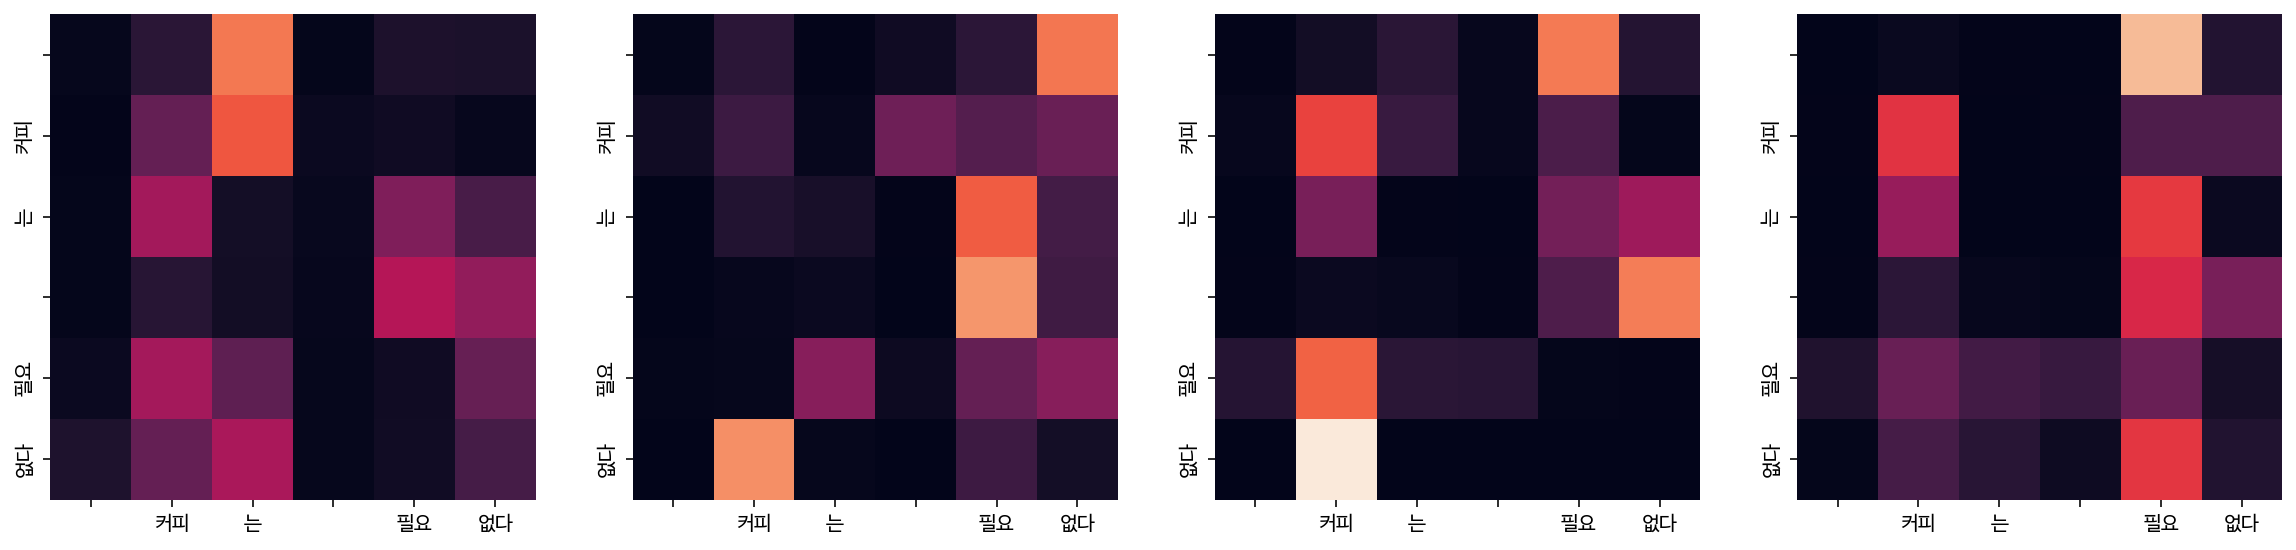

Encoder Layer 2


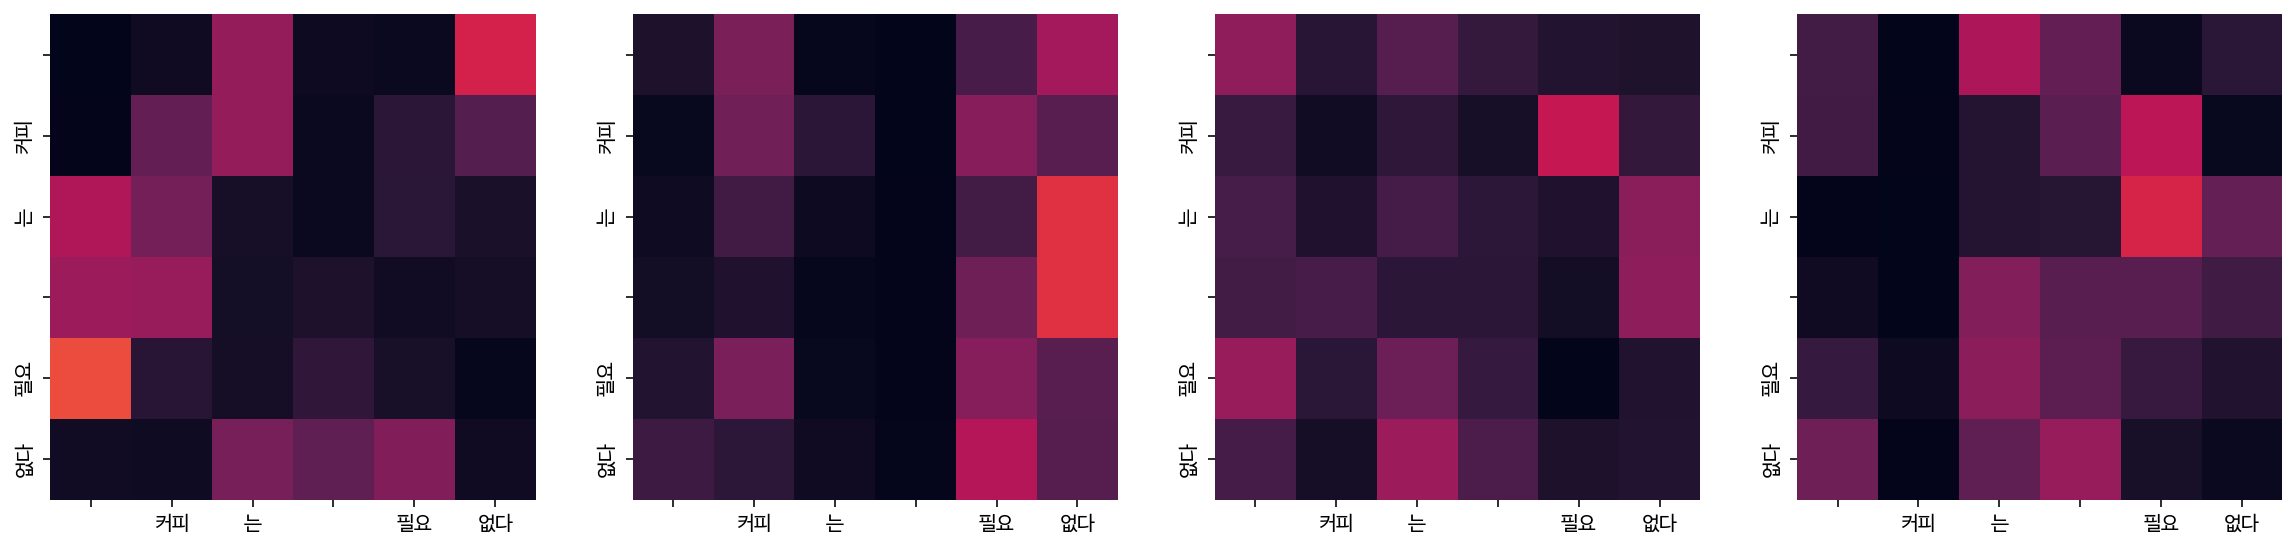

Decoder Self Layer 1


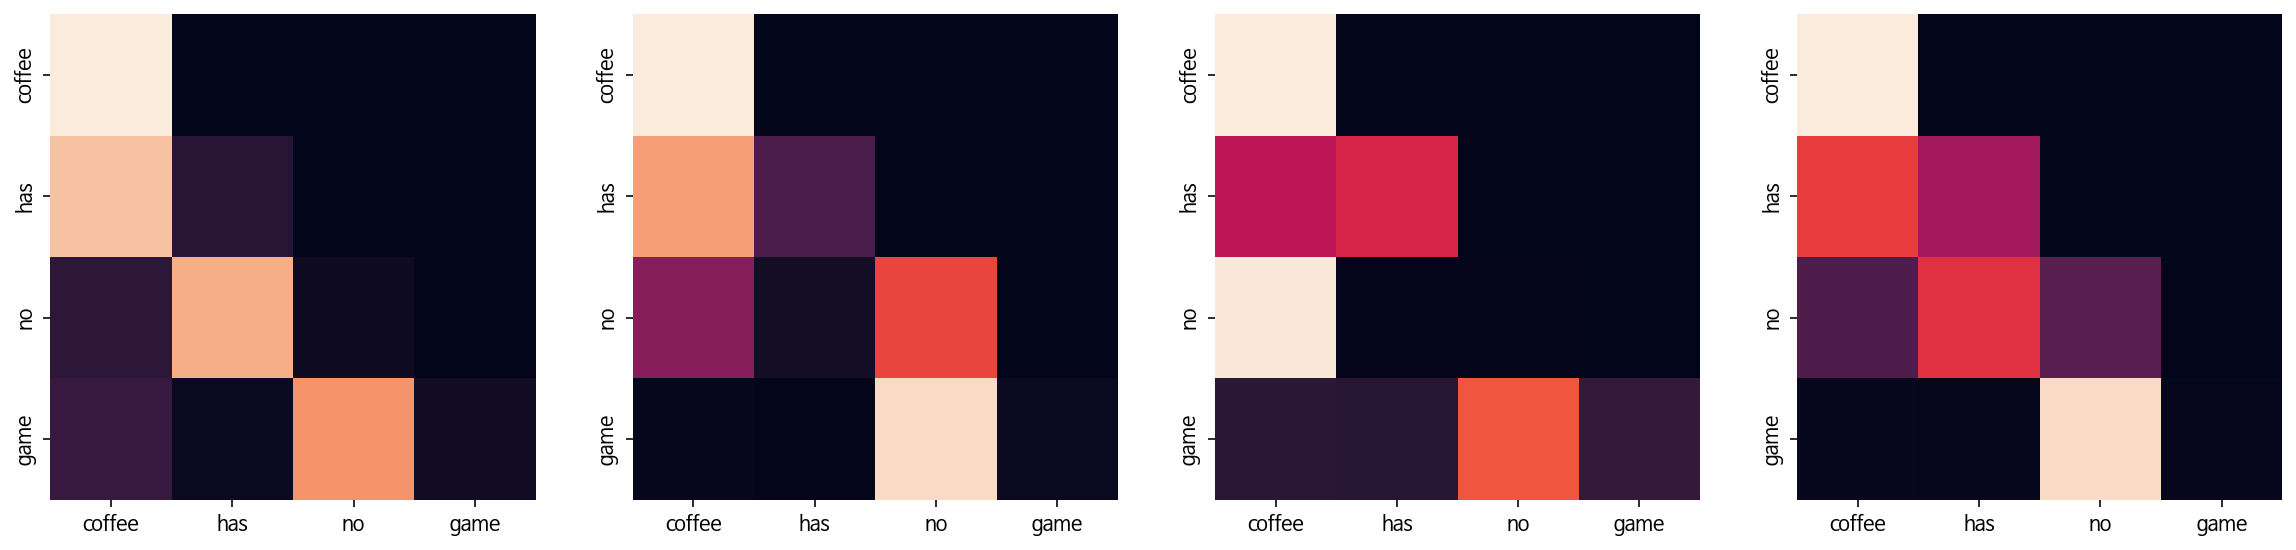

Decoder Src Layer 1


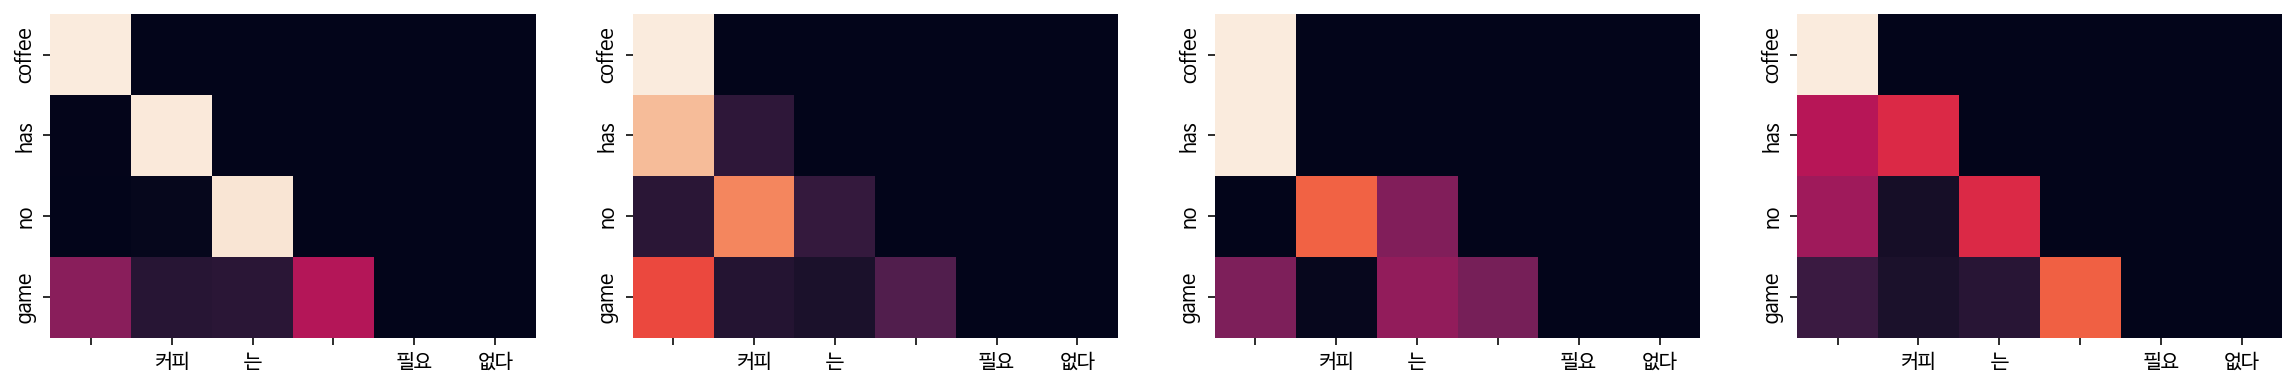

Decoder Self Layer 2


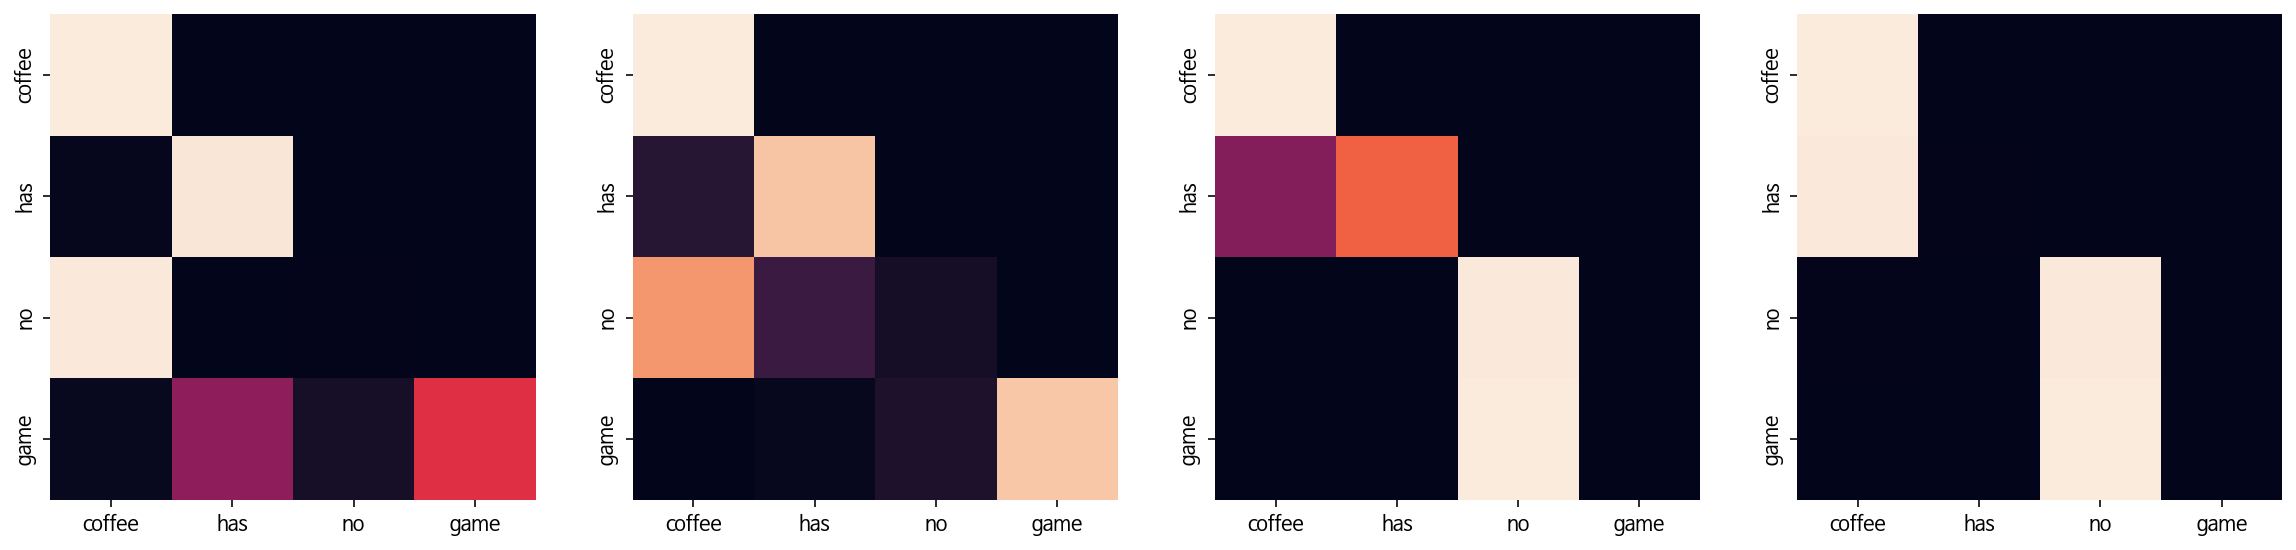

Decoder Src Layer 2


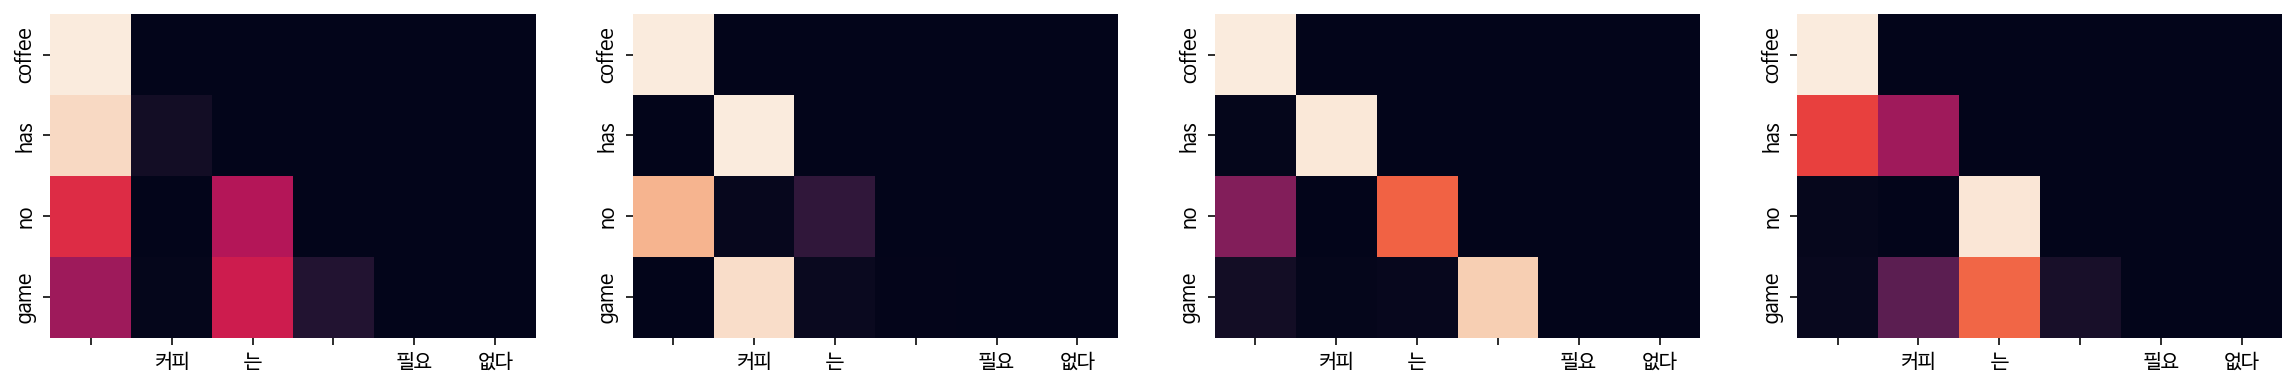

In [30]:
translate("커피는 필요없다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven were dead states
Encoder Layer 1


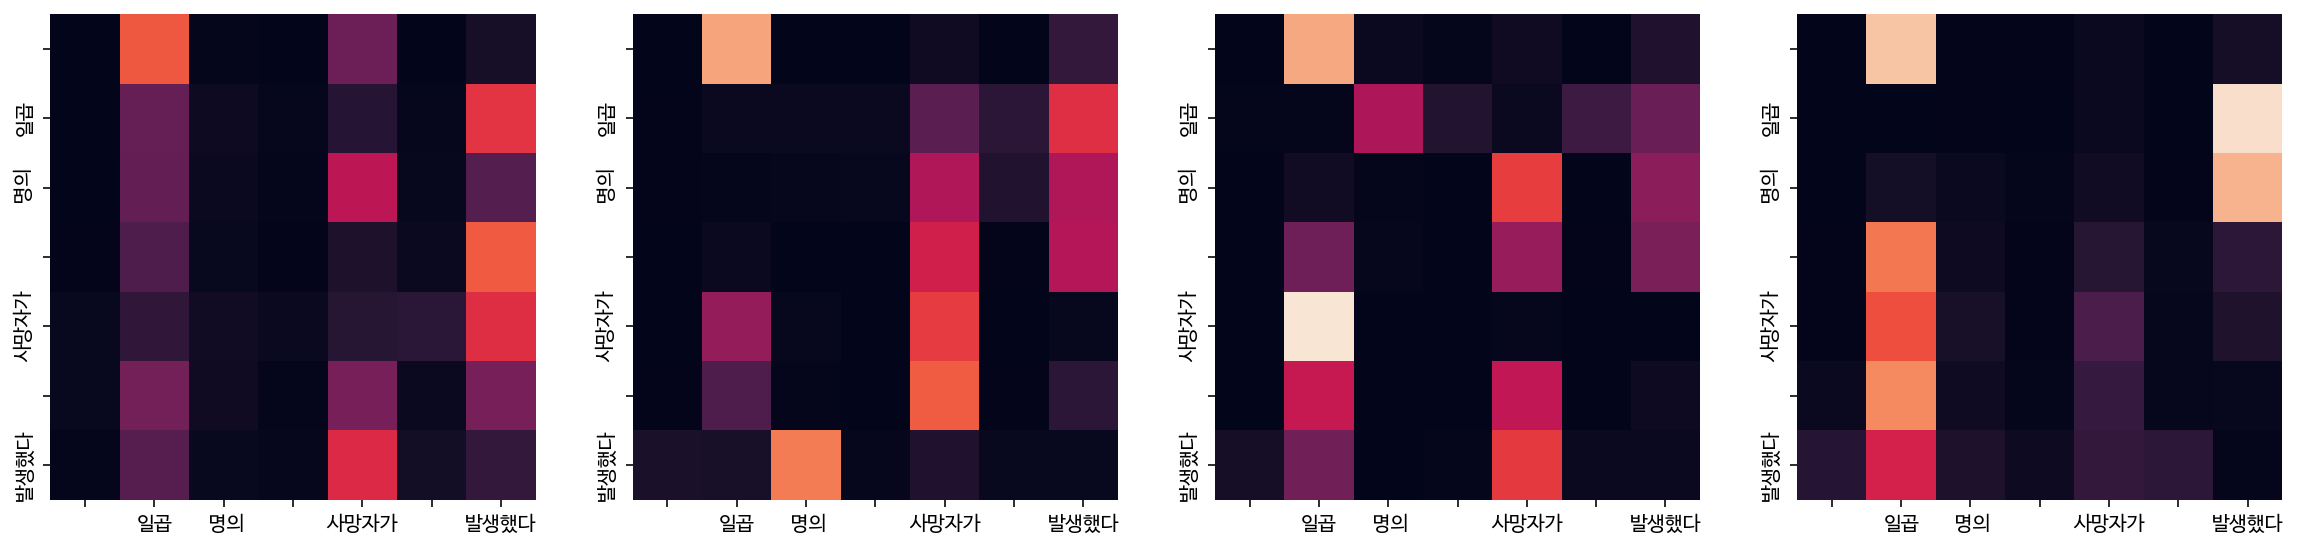

Encoder Layer 2


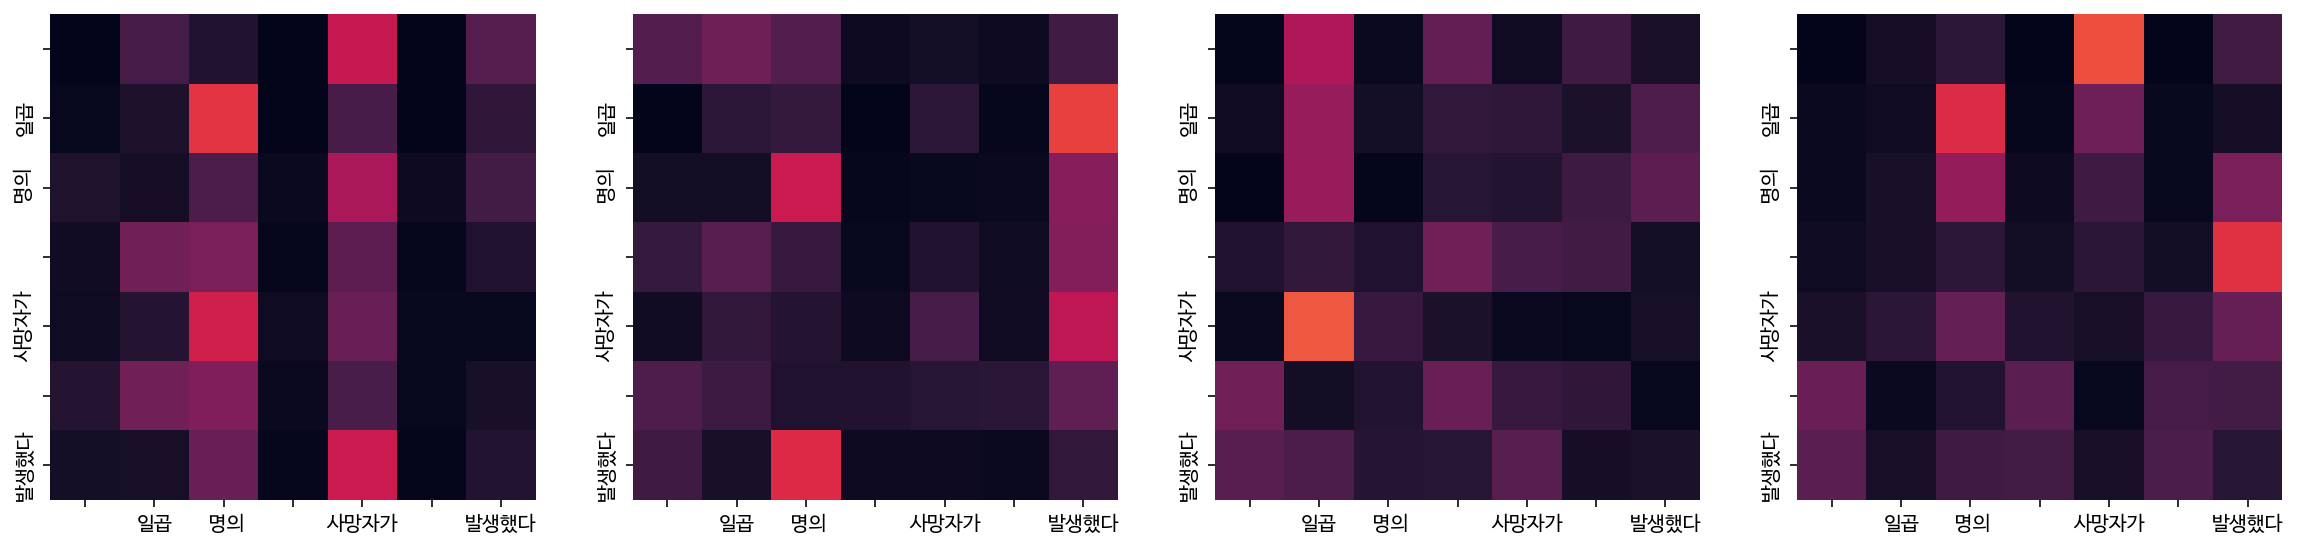

Decoder Self Layer 1


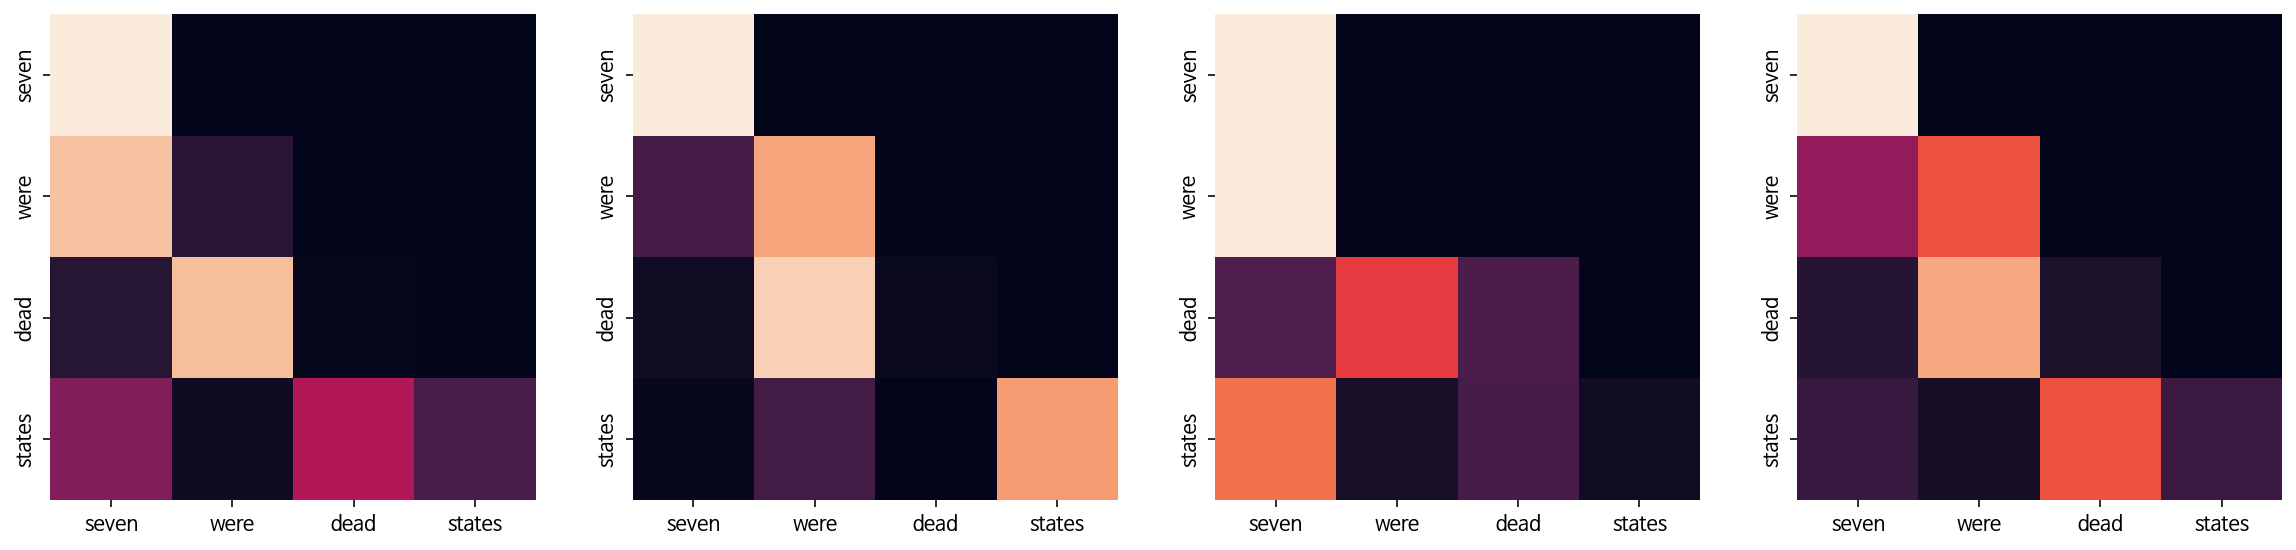

Decoder Src Layer 1


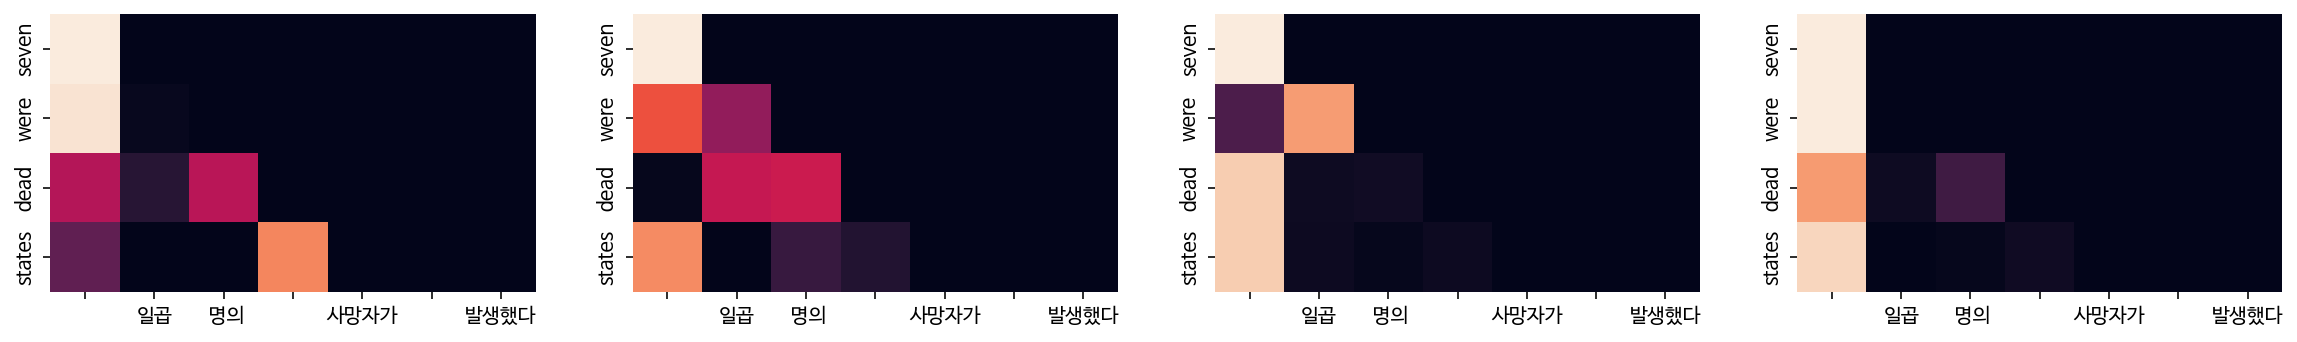

Decoder Self Layer 2


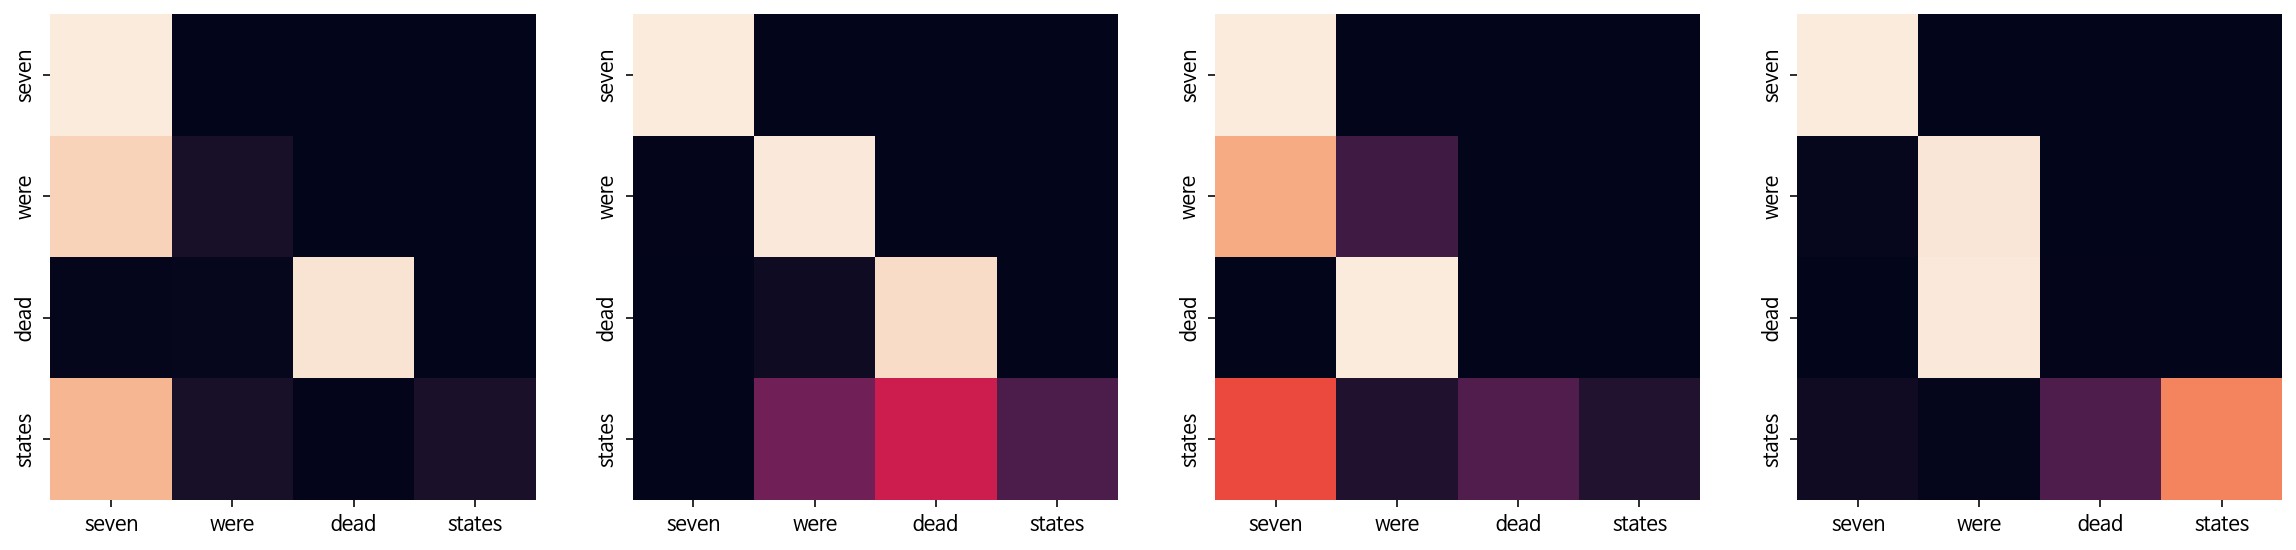

In [ ]:
translate("일곱 명의 사망자가 발생했다.", transformer, ko_tokenizer, en_tokenizer, plot_attention=True)